In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

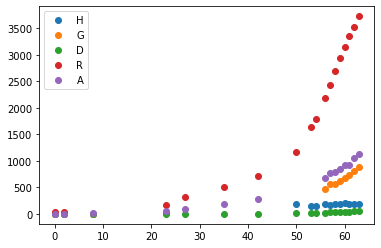

In [3]:
time = [0,2,8,23,27,35,42,50,53,54,56,57,58, 59,60,61,62,63]
S = [141105] + [None]*(len(time)-1)
R = [54874] + [None]*(len(time)-1)
H = [0, 0, 0, 11, None, None, None, 189, 147, 147, 183, 176, 193,  190, 197, 189, 191, 183]
G = [4, 7, 7, 37, None, None, None, None, None, None, 471, 558, 572,  620, 676, 727, 809, 893]
D = [0, 0, 1, 1, 3, 3, 6, 16, 20, 22, 25, 32, 33,  39, 42, 44, 48, 53]
cE = [28, 36, None, 169, 314, 513, 716, 1174, 1644, 1797, 2194, 2437, 2686,  2936, 3149, 3357, 3530, 3728]
cH = [4, 7, 8, 49, 91, 195, 290, None, None, None, 679, 766, 798,  849, 915, 915, 1048, 1129]

plt.plot(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

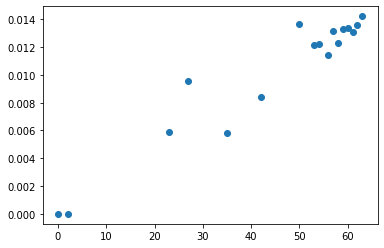

In [4]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [5]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
p0 = [1.5, 1/8, 0, 1/8, 1/8, 0.02]
config = {
    "grid_size": 59*2,
    "basis_number": 29,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.5],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        [1]*len(time)
    ],
    "regularisation_value": copy(p0),
}

In [6]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [7]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [8]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [9]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3969
Number of nonzeros in Lagrangian Hessian.............:     5196

Total number of variables............................:      267
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

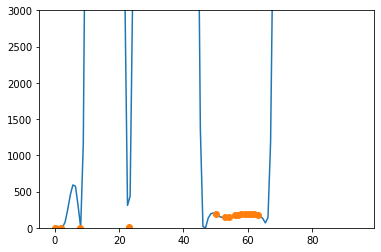

In [10]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [11]:
prange = np.logspace(-6, 8, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3969
Number of nonzeros in Lagrangian Hessian.............:     5196

Total number of variables............................:      267
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1062
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1062
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

  50  1.5577011e+02 0.00e+00 1.30e-01  -5.7 9.65e+02 -13.0 1.00e+00 1.00e+00f  1
  60  1.5576899e+02 0.00e+00 1.87e-01  -5.7 7.96e+03    -  1.00e+00 2.50e-01f  3
  70  1.5576844e+02 0.00e+00 3.60e-02  -5.7 5.34e+01 -11.0 1.00e+00 1.00e+00f  1
  80  1.5576820e+02 0.00e+00 7.12e-02  -5.7 3.93e+03    -  1.00e+00 2.50e-01h  3
  90  1.5576808e+02 0.00e+00 9.84e-02  -5.7 6.24e+03    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5576804e+02 0.00e+00 1.28e-02  -5.7 2.33e+02    -  1.00e+00 5.00e-01h  2
 110  1.5576801e+02 0.00e+00 1.31e-01  -8.6 5.23e+03    -  7.24e-01 3.45e-01f  2
 120  1.5576788e+02 0.00e+00 2.70e-02  -8.6 7.32e+04    -  1.00e+00 1.40e-01h  1

Number of Iterations....: 129

                                   (scaled)                 (unscaled)
Objective...............:   1.5576787734946424e+02    1.5576787734946424e+02
Dual infeasibility......:   7.2427893524162961e-09    7.2427893524162961e-09
Constraint vio

 120  1.5655804e+02 0.00e+00 2.62e-02  -8.6 2.02e+02    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 126

                                   (scaled)                 (unscaled)
Objective...............:   1.5655803686615587e+02    1.5655803686615587e+02
Dual infeasibility......:   5.1608127778131852e-09    5.1608127778131852e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   5.1608127778131852e-09    5.1608127778131852e-09


Number of objective function evaluations             = 217
Number of objective gradient evaluations             = 127
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 217
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 127
Number of Lagrangian Hessian evaluations             = 126
Total CPU secs in IP

  60  1.5925336e+02 0.00e+00 4.40e-01  -5.7 3.45e+04    -  1.00e+00 2.50e-01f  3
  70  1.5925243e+02 0.00e+00 4.69e-01  -5.7 3.31e+03 -13.8 1.00e+00 5.00e-01f  2
  80  1.5925210e+02 0.00e+00 2.41e-01  -5.7 1.23e+04    -  1.00e+00 5.00e-01h  2
  90  1.5925200e+02 0.00e+00 2.10e-02  -5.7 5.51e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5925183e+02 0.00e+00 7.63e-02  -8.6 2.64e+05    -  3.43e-01 1.59e-02f  2

Number of Iterations....: 107

                                   (scaled)                 (unscaled)
Objective...............:   1.5925181862999173e+02    1.5925181862999173e+02
Dual infeasibility......:   3.8287387775528892e-09    3.8287387775528892e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059036595343031e-09    2.5059036595343031e-09
Overall NLP error.......:   3.8287387775528892e-09    3.8287387775528892e-09


Number of objective func

  30  1.6320983e+02 0.00e+00 1.13e+01  -3.8 2.96e+03 -10.3 1.00e+00 5.00e-01f  2
  40  1.6306132e+02 0.00e+00 6.98e+00  -3.8 5.36e+03 -11.8 1.00e+00 1.00e+00f  1
  50  1.6304384e+02 0.00e+00 1.04e-01  -5.7 1.38e+03    -  1.00e+00 1.00e+00f  1
  60  1.6304356e+02 0.00e+00 1.66e-10  -8.6 2.90e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 60

                                   (scaled)                 (unscaled)
Objective...............:   1.6304356440696395e+02    1.6304356440696395e+02
Dual infeasibility......:   1.6612241645332609e-10    1.6612241645332609e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.6669220648071760e-09    5.6669220648071760e-09
Overall NLP error.......:   5.6669220648071760e-09    5.6669220648071760e-09


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 61
Number of equality constraint evaluations            = 0
Number of ineq

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3969
Number of nonzeros in Lagrangian Hessian.............:     5196

Total number of variables............................:      267
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1062
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1062
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6578628e+02 0.00e+00 1.22e+00  -1.0 0.00e+00    -  0.00e+00 0.

  40  1.6955880e+02 0.00e+00 1.06e-01  -5.7 1.25e+02 -10.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:   1.6955861356718592e+02    1.6955861356718592e+02
Dual infeasibility......:   5.7345921882184504e-09    5.7345921882184504e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.1992436886398008e-09    5.1992436886398008e-09
Overall NLP error.......:   5.7345921882184504e-09    5.7345921882184504e-09


Number of objective function evaluations             = 61
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 61
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 50
Number of Lagrangian Hessian evaluations             = 49
Total CPU secs in IPOPT (w

  20  1.7660148e+02 0.00e+00 9.36e+01  -2.5 2.17e+04    -  5.06e-01 1.25e-01f  3
  30  1.7527111e+02 0.00e+00 2.05e+01  -2.5 9.02e+03    -  1.00e+00 2.50e-01f  3
  40  1.7527759e+02 0.00e+00 3.20e-01  -2.5 1.69e+02    -  1.00e+00 1.00e+00f  1
  50  1.7482276e+02 0.00e+00 2.33e+00  -3.8 1.17e+03 -11.3 1.00e+00 1.00e+00f  1
  60  1.7479506e+02 0.00e+00 3.24e+01  -3.8 6.16e+03 -11.9 1.00e+00 1.00e+00f  1
  70  1.7473973e+02 0.00e+00 8.83e+00  -3.8 7.22e+02  -9.9 1.00e+00 1.00e+00f  1
  80  1.7471878e+02 0.00e+00 2.23e+00  -5.7 5.50e+03    -  8.37e-01 4.65e-01f  1
  90  1.7471242e+02 0.00e+00 1.23e-08  -5.7 6.84e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 95

                                   (scaled)                 (unscaled)
Objective...............:   1.7471237482745957e+02    1.7471237482745957e+02
Dual infeasibility......:   1.6888129596126678e-09    1.6888129596126678e-09
Constraint viol

  30  1.8371790e+02 0.00e+00 3.67e-01  -2.5 2.36e+02  -8.9 1.00e+00 1.00e+00f  1
  40  1.8376287e+02 0.00e+00 3.42e+01  -2.5 2.51e+03    -  1.00e+00 5.00e-01f  2
  50  1.8378807e+02 0.00e+00 1.17e+00  -2.5 1.84e+02 -10.9 1.00e+00 1.00e+00f  1
  60  1.8341353e+02 0.00e+00 6.00e-01  -3.8 4.23e+02  -9.1 1.00e+00 1.00e+00f  1
  70  1.8336184e+02 0.00e+00 4.46e-01  -3.8 2.23e+02  -9.8 1.00e+00 1.00e+00f  1
  80  1.8328904e+02 0.00e+00 1.96e+01  -3.8 2.01e+03 -11.0 1.00e+00 1.00e+00f  1
  90  1.8323445e+02 0.00e+00 7.06e+00  -3.8 4.87e+02 -10.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.8321885e+02 0.00e+00 7.02e-03  -5.7 1.20e+02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 107

                                   (scaled)                 (unscaled)
Objective...............:   1.8321877633173241e+02    1.8321877633173241e+02
Dual infeasibility......:   8.5266699087782324e-10    8.5266699087782324e-10
Constraint vio

 130  1.9201144e+02 0.00e+00 1.26e-01  -8.6 7.63e+00    -  9.53e-01 7.53e-01f  1

Number of Iterations....: 134

                                   (scaled)                 (unscaled)
Objective...............:   1.9201143854842388e+02    1.9201143854842388e+02
Dual infeasibility......:   2.1282836188787981e-09    2.1282836188787981e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.0479417033424433e-09    2.0479417033424433e-09
Overall NLP error.......:   2.1282836188787981e-09    2.1282836188787981e-09


Number of objective function evaluations             = 259
Number of objective gradient evaluations             = 135
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 259
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 135
Number of Lagrangian Hessian evaluations             = 134
Total CPU secs in IP

  40  2.0934338e+02 0.00e+00 4.52e-06  -5.7 1.06e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                   (scaled)                 (unscaled)
Objective...............:   2.0934332690595562e+02    2.0934332690595562e+02
Dual infeasibility......:   4.6999614305295423e-09    4.6999614305295423e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.8157168040648079e-09    7.8157168040648079e-09
Overall NLP error.......:   7.8157168040648079e-09    7.8157168040648079e-09


Number of objective function evaluations             = 49
Number of objective gradient evaluations             = 46
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 49
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 46
Number of Lagrangian Hessian evaluations             = 45
Total CPU secs in IPOPT (w

  50  2.3318154e+02 0.00e+00 2.55e+00  -2.5 9.32e+02    -  1.00e+00 5.00e-01f  2
  60  2.3301222e+02 0.00e+00 6.30e-01  -3.8 3.13e+02 -10.4 1.00e+00 1.00e+00f  1
  70  2.3299564e+02 0.00e+00 1.42e-01  -3.8 4.90e+01  -8.9 1.00e+00 1.00e+00f  1
  80  2.3297043e+02 0.00e+00 3.28e+00  -3.8 8.16e+02 -10.9 1.00e+00 1.00e+00f  1
  90  2.3294930e+02 0.00e+00 3.01e+00  -3.8 5.77e+02 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3292495e+02 0.00e+00 8.65e+00  -3.8 1.07e+03 -10.5 1.00e+00 1.00e+00f  1
 110  2.3289050e+02 0.00e+00 9.67e+00  -3.8 1.37e+03 -10.8 1.00e+00 1.00e+00f  1
 120  2.3281476e+02 0.00e+00 1.71e+01  -3.8 1.83e+03 -10.1 1.00e+00 5.00e-01f  2
 130  2.3269029e+02 0.00e+00 1.84e+01  -3.8 7.52e+06  -9.5 1.14e-03 7.95e-05f  4
 140  2.3253184e+02 0.00e+00 5.89e-01  -3.8 9.82e+01  -8.4 1.00e+00 1.00e+00f  1
 150  2.3240054e+02 0.00e+00 2.74e+00  -3.8 1.30e+04    -  6.74e-01 6.25e-02f  5
 160  2.3238522e+02 0.00e+00

  10  2.6971810e+02 0.00e+00 6.41e-02  -1.7 6.27e+00  -4.5 1.00e+00 1.00e+00f  1
  20  2.6663075e+02 0.00e+00 4.16e+00  -2.5 5.05e+03    -  1.00e+00 1.00e+00f  1
  30  2.6645364e+02 0.00e+00 5.48e-02  -3.8 8.33e+02    -  1.00e+00 1.00e+00h  1
  40  2.6644549e+02 0.00e+00 8.46e-04  -8.6 1.39e+03    -  9.75e-01 6.09e-01f  1

Number of Iterations....: 44

                                   (scaled)                 (unscaled)
Objective...............:   2.6644548196357078e+02    2.6644548196357078e+02
Dual infeasibility......:   6.2804380152068367e-11    6.2804380152068367e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2009407904755167e-09    3.2009407904755167e-09
Overall NLP error.......:   3.2009407904755167e-09    3.2009407904755167e-09


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 45
Number of equality constraint evaluations            = 0
Number of ineq

 320  3.1470105e+02 0.00e+00 1.01e+02  -1.7 2.29e+02  -9.9 1.00e+00 1.00e+00f  1
 330  3.1435014e+02 0.00e+00 3.11e+02  -1.7 2.61e+03    -  1.00e+00 2.50e-01f  3
 340  3.1404170e+02 0.00e+00 6.11e-03  -1.7 2.45e+00    -  1.00e+00 1.00e+00h  1
 350  3.1136301e+02 0.00e+00 1.81e+02  -3.8 1.60e+01  -5.7 1.00e+00 1.00e+00f  1
 360  3.1078683e+02 0.00e+00 1.49e-02  -3.8 2.56e-01  -4.2 1.00e+00 1.00e+00f  1
 370  3.1060661e+02 0.00e+00 9.27e+02  -3.8 7.82e+02  -8.9 1.00e+00 1.00e+00f  1
 380  3.0992532e+02 0.00e+00 1.00e+01  -3.8 3.56e+00  -5.6 1.00e+00 1.00e+00f  1
 390  3.0956699e+02 0.00e+00 1.00e-02  -3.8 2.94e+00  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  3.0924092e+02 0.00e+00 2.30e+00  -5.7 3.58e+01  -7.4 1.00e+00 8.72e-01f  1
 410  3.0890403e+02 0.00e+00 6.04e+02  -5.7 4.95e+02  -8.6 1.00e+00 1.00e+00f  1
 420  3.0844300e+02 0.00e+00 2.72e-01  -5.7 4.08e+00  -6.1 1.00e+00 1.00e+00f  1
 430  3.0811982e+02 0.00e+00

  40  3.5372154e+02 0.00e+00 1.81e-05  -8.6 1.02e-01    -  1.00e+00 9.04e-01f  1

Number of Iterations....: 42

                                   (scaled)                 (unscaled)
Objective...............:   3.5372153774341052e+02    3.5372153774341052e+02
Dual infeasibility......:   1.9416202529222544e-11    1.9416202529222544e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.2900433886772197e-09    1.2900433886772197e-09
Overall NLP error.......:   1.2900433886772197e-09    1.2900433886772197e-09


Number of objective function evaluations             = 54
Number of objective gradient evaluations             = 43
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 54
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 43
Number of Lagrangian Hessian evaluations             = 42
Total CPU secs in IPOPT (w

  40  4.7812804e+02 0.00e+00 2.46e+02  -2.5 1.73e+02  -6.8 1.00e+00 1.00e+00f  1
  50  4.7365055e+02 0.00e+00 6.34e+01  -2.5 1.24e+04    -  1.00e+00 1.25e-01f  4
  60  4.7220622e+02 0.00e+00 6.45e+00  -2.5 1.93e+03    -  1.00e+00 1.00e+00f  1
  70  4.7209348e+02 0.00e+00 2.96e-04  -5.7 4.77e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 74

                                   (scaled)                 (unscaled)
Objective...............:   4.7209343004177708e+02    4.7209343004177708e+02
Dual infeasibility......:   8.3326559895794041e-10    8.3326559895794041e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.3118652304899360e-09    5.3118652304899360e-09
Overall NLP error.......:   5.3118652304899360e-09    5.3118652304899360e-09


Number of objective function evaluations             = 127
Number of objective gradient evaluations             = 75
Number of equality constraint evaluations            = 0
Number of ine

  10  6.6895528e+02 0.00e+00 5.30e-01  -1.7 5.48e-01  -3.0 1.00e+00 1.00e+00f  1
  20  6.6819503e+02 0.00e+00 1.98e+01  -3.8 7.09e+03    -  9.33e-01 1.00e+00f  1
  30  6.6813022e+02 0.00e+00 8.62e-06  -8.6 1.38e-02    -  1.00e+00 9.58e-01f  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:   6.6813021583033299e+02    6.6813021583033299e+02
Dual infeasibility......:   6.2848383817887134e-11    6.2848383817887134e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5470696492657302e-09    1.5470696492657302e-09
Overall NLP error.......:   1.5470696492657302e-09    1.5470696492657302e-09


Number of objective function evaluations             = 46
Number of objective gradient evaluations             = 33
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 46
Number of equality constraint Jacobia

  30  9.7337264e+02 0.00e+00 1.04e-04  -8.6 1.09e+01    -  1.00e+00 5.38e-01h  1

Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   9.7337264252704017e+02    9.7337264252704017e+02
Dual infeasibility......:   1.5537425425560164e-11    1.5537425425560164e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.3351726368963295e-09    2.3351726368963295e-09
Overall NLP error.......:   2.3351726368963295e-09    2.3351726368963295e-09


Number of objective function evaluations             = 44
Number of objective gradient evaluations             = 34
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 44
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 34
Number of Lagrangian Hessian evaluations             = 33
Total CPU secs in IPOPT (w

  10  1.5456683e+03 0.00e+00 1.38e+01  -1.7 1.02e+00  -2.5 1.00e+00 1.00e+00f  1
  20  1.5451208e+03 0.00e+00 5.97e-01  -3.8 7.39e+02    -  1.00e+00 1.00e+00f  1
  30  1.5451143e+03 0.00e+00 7.84e-10  -8.6 3.16e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   1.5451143417050191e+03    1.5451143417050191e+03
Dual infeasibility......:   7.8439771354518137e-10    7.8439771354518137e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060797349397207e-09    2.5060797349397207e-09
Overall NLP error.......:   2.5060797349397207e-09    2.5060797349397207e-09


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 31
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobia

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3969
Number of nonzeros in Lagrangian Hessian.............:     5196

Total number of variables............................:      267
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1062
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1062
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2548368e+03 0.00e+00 7.83e+01  -1.0 0.00e+00    -  0.00e+00 0.

  20  2.7916998e+03 0.00e+00 6.29e+01  -2.5 2.43e+03    -  1.00e+00 1.00e+00f  1
  30  2.7915812e+03 0.00e+00 5.94e-04  -8.6 3.05e-02  -6.5 1.00e+00 8.14e-01h  1
  40  2.7915770e+03 0.00e+00 2.13e+00  -8.6 1.92e+03 -11.3 1.00e+00 1.00e+00f  1
  50  2.7915390e+03 0.00e+00 1.08e+00  -8.6 8.56e+02 -10.6 1.00e+00 1.00e+00f  1
  60  2.7914819e+03 0.00e+00 1.49e+01  -8.6 6.38e+02  -9.1 1.00e+00 5.00e-01f  2
  70  2.7914266e+03 0.00e+00 1.34e-01  -8.6 1.38e+02  -9.3 1.00e+00 1.00e+00f  1
  80  2.7913018e+03 0.00e+00 1.05e+02  -8.6 1.54e+03  -9.6 1.00e+00 5.00e-01f  2
  90  2.7911322e+03 0.00e+00 7.96e+00  -8.6 9.10e+02  -8.9 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7909175e+03 0.00e+00 8.00e+01  -8.6 1.10e+03  -9.2 1.00e+00 5.00e-01f  2
 110  2.7907266e+03 0.00e+00 4.41e+00  -8.6 2.35e+02  -8.5 1.00e+00 1.00e+00f  1
 120  2.7905095e+03 0.00e+00 1.01e-10  -8.6 1.01e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

  20  3.4493023e+03 0.00e+00 8.47e-03  -3.8 1.85e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:   2.7330312592391811e+03    3.4492979981660196e+03
Dual infeasibility......:   1.9368685100419639e-10    2.4444786907627075e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.8962845144507145e-10    1.2489880695502459e-09
Overall NLP error.......:   9.8962845144507145e-10    1.2489880695502459e-09


Number of objective function evaluations             = 30
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 30
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5465418411284407e-09    3.9239304623906240e-09
Overall NLP error.......:   2.5465418411284407e-09    3.9239304623906240e-09


Number of objective function evaluations             = 33
Number of objective gradient evaluations             = 31
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 33
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 31
Number of Lagrangian Hessian evaluations             = 30
Total CPU secs in IPOPT (w/o function evaluations)   =      0.115
Total CPU secs in NLP function evaluations           =      0.035

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.94ms ( 58.67us)   1.93ms ( 58.58us)        33
       nlp_g  | 991.00us ( 30.03us) 985.26us ( 29.86us)        33
  

  10  5.3269114e+03 0.00e+00 4.82e-01  -1.0 2.42e-02  -1.3 1.00e+00 1.00e+00f  1
  20  5.3232124e+03 0.00e+00 3.21e+02  -1.7 2.31e+03    -  1.00e+00 1.00e+00f  1
  30  5.3221479e+03 0.00e+00 2.78e+00  -3.8 1.22e+00  -4.8 1.00e+00 1.00e+00f  1
  40  5.3215043e+03 0.00e+00 3.21e+00  -3.8 3.16e-02  -1.3 1.00e+00 1.00e+00f  1
  50  5.3215016e+03 0.00e+00 1.81e-02  -3.8 1.74e+00  -6.1 1.00e+00 1.00e+00f  1
  60  5.3207760e+03 0.00e+00 1.26e+02  -3.8 2.28e+02  -8.1 1.00e+00 1.00e+00f  1
  70  5.3204772e+03 0.00e+00 9.11e-04  -5.7 1.29e-01    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   2.9546706665097877e+03    5.3204771697071610e+03
Dual infeasibility......:   1.6929421806095783e-09    3.0484819589749295e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059963471651150e-09    4.5125490646344320e-09
Overall NLP error......

Total number of variables............................:      267
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1062
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1062
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.6416385e+03 0.00e+00 1.01e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  6.5830467e+03 0.00e+00 3.20e+03  -1.0 1.41e+03    -  4.75e-01 1.00e+00f  1
  20  6.5698831e+03 0.00e+00 4.24e+02  -2.5 3.04e+02    -  1.00e+00 5.00e-01f  2
  30  6.5695171e+03 0.00e+00 1.13e-01  -3.8 8.40e+00    -  1.00e+00 1.00e+00f  1

Number of Iterati

  30  7.8575268e+03 0.00e+00 1.73e-02  -2.5 3.35e-02  -1.5 1.00e+00 1.00e+00f  1
  40  7.8573840e+03 0.00e+00 1.07e+01  -3.8 1.10e+00  -5.7 1.00e+00 1.00e+00f  1
  50  7.8570616e+03 0.00e+00 9.94e-02  -3.8 1.91e-03  -0.8 1.00e+00 1.00e+00f  1
  60  7.8570602e+03 0.00e+00 4.93e-08  -5.7 5.09e-03    -  1.00e+00 1.00e+00h  1
  70  7.8570601e+03 0.00e+00 4.03e-08  -9.0 2.33e-09    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:   3.9735223074645301e+03    7.8570601450886215e+03
Dual infeasibility......:   2.0299151466215256e-08    4.0138607920912210e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909241012e-10    1.7975945263158988e-09
Overall NLP error.......:   2.0299151466215256e-08    4.0138607920912210e-08


Number of objective function evaluations             = 167
Number of objective gradient evaluations       

 140  8.5814937e+03 0.00e+00 8.39e+00  -3.8 6.54e+01  -8.5 1.00e+00 1.00e+00f  1
 150  8.5814472e+03 0.00e+00 9.89e+00  -3.8 1.74e-01  -5.1 1.00e+00 1.00e+00f  1
 160  8.5812816e+03 0.00e+00 3.47e-03  -3.8 9.58e-01    -  1.00e+00 1.00e+00h  1
 170  8.5812707e+03 0.00e+00 1.98e-07  -8.6 3.16e-09    -  1.00e+00 1.00e+00H  1
 180  8.5812707e+03 0.00e+00 4.75e-08  -8.6 4.94e-09    -  1.00e+00 1.00e+00F  1

Number of Iterations....: 182

                                   (scaled)                 (unscaled)
Objective...............:   4.7345763352417734e+03    8.5812707390253272e+03
Dual infeasibility......:   9.0029533739857305e-08    1.6317569911785555e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    4.5418714091561530e-09
Overall NLP error.......:   9.0029533739857305e-08    1.6317569911785555e-07


Number of objective function evaluations             = 363
Number of objective gradient evaluations      

 660  8.8450433e+03 0.00e+00 2.02e+03  -3.8 4.96e+03    -  1.00e+00 1.38e-01f  2
 670  8.8449998e+03 0.00e+00 4.92e+02  -5.7 3.83e+02    -  1.00e+00 7.22e-01f  1
 680  8.8449989e+03 0.00e+00 1.12e-07  -8.6 4.83e-09    -  1.00e+00 1.00e+00H  1
 690  8.8449989e+03 0.00e+00 1.33e-07  -9.0 4.76e-09    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 691

                                   (scaled)                 (unscaled)
Objective...............:   5.4226828055688793e+03    8.8449989215411370e+03
Dual infeasibility......:   1.8107758078832254e-07    2.9535767888602660e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090941e-10    1.4828284077826298e-09
Overall NLP error.......:   1.8107758078832254e-07    2.9535767888602660e-07


Number of objective function evaluations             = 1277
Number of objective gradient evaluations     

  30  9.1580731e+03 0.00e+00 2.80e+04  -1.0 7.35e+03    -  5.25e-01 3.91e-03f  9
  40  9.1574479e+03 0.00e+00 6.89e+00  -1.0 1.30e-02  -1.1 1.00e+00 1.00e+00f  1
  50  9.1570557e+03 0.00e+00 2.36e+04  -1.0 6.17e+02    -  5.75e-01 6.25e-02f  5
  60  9.1554995e+03 0.00e+00 2.75e+02  -1.0 2.02e-01  -2.3 1.00e+00 1.00e+00f  1
  70  9.1549772e+03 0.00e+00 1.79e+04  -1.0 6.34e+00  -3.9 1.00e+00 1.00e+00f  1
  80  9.1544763e+03 0.00e+00 1.67e+04  -1.0 4.24e+03    -  6.23e-01 7.81e-03f  8
  90  9.1537838e+03 0.00e+00 3.44e+04  -1.0 3.10e+03    -  6.30e-01 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.1529893e+03 0.00e+00 3.70e+04  -1.0 6.94e+02    -  6.39e-01 6.25e-02f  5
 110  9.1505496e+03 0.00e+00 1.71e+03  -2.5 7.83e-01  -2.3 1.00e+00 1.00e+00f  1
 120  9.1493845e+03 0.00e+00 2.69e+04  -2.5 2.46e+00  -3.4 1.00e+00 1.00e+00f  1
 130  9.1488058e+03 0.00e+00 4.86e-01  -2.5 6.96e-02  -2.2 1.00e+00 1.00e+00f  1
 140  9.1483927e+03 0.00e+00

 990  9.1421117e+03 0.00e+00 7.15e-01  -5.7 4.92e-03  -4.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  9.1421114e+03 0.00e+00 6.98e+01  -5.7 5.76e+01  -9.3 1.00e+00 1.00e+00f  1
1010  9.1421108e+03 0.00e+00 4.80e+02  -5.7 1.05e+02  -9.6 1.00e+00 1.00e+00f  1
1020  9.1421103e+03 0.00e+00 9.22e+02  -5.7 2.59e+02  -9.8 1.00e+00 2.50e-01f  3
1030  9.1421101e+03 0.00e+00 1.00e+00  -5.7 5.90e-02  -6.3 1.00e+00 1.00e+00h  1
1040  9.1421096e+03 0.00e+00 4.40e+00  -5.7 1.01e-01  -5.6 1.00e+00 1.00e+00h  1
1050  9.1421090e+03 0.00e+00 1.01e+01  -5.7 1.12e-02  -3.2 1.00e+00 1.00e+00f  1
1060  9.1421089e+03 0.00e+00 2.32e+00  -5.7 2.53e+00  -8.0 1.00e+00 1.00e+00h  1
1070  9.1421084e+03 0.00e+00 1.06e-01  -5.7 5.77e-01  -7.3 1.00e+00 1.00e+00h  1
1080  9.1421075e+03 0.00e+00 3.69e-04  -5.7 1.63e-02  -5.8 1.00e+00 1.00e+00h  1
1090  9.1421069e+03 0.00e+00 1.42e+02  -5.7 5.46e-01  -6.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

1920  9.1420577e+03 0.00e+00 2.85e+00  -5.7 3.07e-01  -6.7 1.00e+00 1.00e+00h  1
1930  9.1420569e+03 0.00e+00 7.94e-01  -5.7 3.10e-03  -3.2 1.00e+00 1.00e+00h  1
1940  9.1420568e+03 0.00e+00 9.81e-01  -5.7 3.83e+00  -8.0 1.00e+00 1.00e+00h  1
1950  9.1420562e+03 0.00e+00 1.37e-01  -5.7 8.69e-01  -7.3 1.00e+00 1.00e+00h  1
1960  9.1420546e+03 0.00e+00 4.04e+02  -5.7 1.00e+02  -9.4 1.00e+00 1.00e+00f  1
1970  9.1420545e+03 0.00e+00 2.91e-01  -5.7 2.82e+00  -7.8 1.00e+00 1.00e+00h  1
1980  9.1420509e+03 0.00e+00 4.82e+02  -5.7 1.06e-01  -3.0 1.00e+00 5.00e-01f  2
1990  9.1420508e+03 0.00e+00 3.06e-03  -8.6 8.58e-03    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  9.1420508e+03 0.00e+00 6.09e-07  -8.6 3.45e-08    -  1.00e+00 1.00e+00H  1
2010  9.1420508e+03 0.00e+00 7.85e-07  -8.6 2.14e-08    -  1.00e+00 1.00e+00H  1
2020  9.1420508e+03 0.00e+00 6.99e-07  -8.6 1.14e-08    -  1.00e+00 1.00e+00H  1
2030  9.1420508e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  9.2936272e+03 0.00e+00 3.72e+00  -3.8 1.95e+00  -6.8 1.00e+00 5.00e-01f  2
 310  9.2923488e+03 0.00e+00 5.47e-01  -3.8 2.27e-01  -5.7 1.00e+00 1.00e+00h  1
 320  9.2930210e+03 0.00e+00 4.28e+00  -3.8 1.43e+00  -6.8 1.00e+00 5.00e-01h  2
 330  9.2923128e+03 0.00e+00 8.91e-01  -3.8 3.05e-01  -6.1 1.00e+00 1.00e+00h  1
 340  9.2925205e+03 0.00e+00 1.98e-02  -3.8 2.39e-02  -4.5 1.00e+00 1.00e+00f  1
 350  9.2924378e+03 0.00e+00 1.92e+01  -3.8 1.29e+01  -7.8 1.00e+00 5.00e-01f  2
 360  9.2925529e+03 0.00e+00 1.41e-02  -3.8 3.45e-02  -5.3 1.00e+00 1.00e+00f  1
 370  9.2913549e+03 0.00e+00 5.68e-02  -3.8 4.81e-01  -6.5 1.00e+00 1.00e+00f  1
 380  9.2910569e+03 0.00e+00 2.30e-03  -3.8 2.59e-02  -5.3 1.00e+00 1.00e+00f  1
 390  9.2658909e+03 0.00e+00 5.30e+00  -5.7 3.25e+00  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  9.2610780e+03 0.00e+00

 320  9.5350704e+03 0.00e+00 2.03e-02  -3.8 1.37e-01  -5.8 1.00e+00 1.00e+00f  1
 330  9.5349747e+03 0.00e+00 3.70e-03  -3.8 6.38e-02  -5.6 1.00e+00 1.00e+00f  1
 340  9.5352594e+03 0.00e+00 8.55e+00  -3.8 6.40e+03    -  9.02e-01 3.91e-03f  9
 350  9.5395157e+03 0.00e+00 6.44e+00  -3.8 9.46e+04    -  2.38e-01 1.12e-03f  9
 360  9.5379145e+03 0.00e+00 2.94e-02  -3.8 2.04e-01  -6.1 1.00e+00 1.00e+00h  1
 370  9.5394713e+03 0.00e+00 3.11e+00  -3.8 3.79e+04    -  3.15e-01 7.90e-04f 10
 380  9.5383641e+03 0.00e+00 7.29e-01  -3.8 7.41e-01  -6.5 1.00e+00 1.00e+00h  1
 390  9.5385976e+03 0.00e+00 1.45e-02  -3.8 3.78e-01  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  9.5358700e+03 0.00e+00 2.15e+00  -3.8 1.30e+00  -6.6 1.00e+00 1.00e+00h  1
 410  9.5375265e+03 0.00e+00 2.77e+00  -3.8 1.71e+00  -6.8 1.00e+00 1.00e+00h  1
 420  9.5402350e+03 0.00e+00 1.80e-01  -3.8 8.21e-01  -6.6 1.00e+00 1.00e+00h  1
 430  9.5422444e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.9458044e+03 0.00e+00 1.81e+00  -3.8 2.33e+00  -6.9 1.00e+00 1.00e+00f  1
 210  9.9294106e+03 0.00e+00 4.54e-02  -3.8 9.72e-01  -6.7 1.00e+00 1.00e+00h  1
 220  9.9171617e+03 0.00e+00 3.60e-04  -3.8 2.31e-01  -6.0 1.00e+00 1.00e+00h  1
 230  9.5855899e+03 0.00e+00 7.07e+00  -5.7 8.19e+00  -6.3 1.00e+00 1.25e-01f  4
 240  9.5561771e+03 0.00e+00 6.74e+00  -5.7 2.06e+00  -6.6 1.00e+00 1.00e+00f  1
 250  9.5405525e+03 0.00e+00 2.04e-01  -5.7 1.29e+00  -6.8 1.00e+00 1.00e+00h  1
 260  9.5339999e+03 0.00e+00 1.53e-02  -5.7 9.80e-02  -6.2 1.00e+00 1.00e+00f  1
 270  9.5314965e+03 0.00e+00 1.24e+00  -5.7 1.35e+00  -8.2 1.00e+00 1.00e+00h  1
 280  9.5299909e+03 0.00e+00 1.15e+00  -5.7 8.84e+03    -  7.04e-01 9.30e-04f 10
 290  9.5287091e+03 0.00e+00 1.78e+00  -5.7 1.94e+00  -8.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  9.5273694e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6590660e+04 0.00e+00 6.77e+00  -3.8 2.46e+00  -5.3 1.00e+00 1.00e+00f  1
 210  1.4290890e+04 0.00e+00 2.64e+02  -3.8 1.35e+01  -6.5 1.00e+00 1.00e+00f  1
 220  1.3493556e+04 0.00e+00 4.10e+01  -3.8 4.57e+00  -5.8 1.00e+00 1.00e+00f  1
 230  1.2757602e+04 0.00e+00 3.55e+01  -3.8 6.23e+00  -6.1 1.00e+00 1.00e+00f  1
 240  1.2277482e+04 0.00e+00 2.99e+00  -3.8 1.35e+00  -5.4 1.00e+00 1.00e+00f  1
 250  1.1646165e+04 0.00e+00 2.65e+01  -3.8 9.80e+00  -6.6 1.00e+00 1.00e+00f  1
 260  1.1186576e+04 0.00e+00 4.27e+01  -3.8 2.81e+01  -6.8 1.00e+00 1.25e-01f  4
 270  1.0961445e+04 0.00e+00 4.71e+01  -3.8 5.26e+00  -6.2 1.00e+00 1.00e+00f  1
 280  1.0784069e+04 0.00e+00 1.20e+00  -3.8 1.07e+00  -5.5 1.00e+00 1.00e+00f  1
 290  1.0619734e+04 0.00e+00 3.25e+00  -3.8 1.82e+00  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.0428645e+04 0.00e+00

 160  8.7599001e+05 0.00e+00 3.64e+00  -1.7 2.79e+00  -4.9 1.00e+00 1.00e+00f  1
 170  8.8439235e+05 0.00e+00 3.99e+02  -1.7 2.61e+02  -6.9 1.00e+00 1.25e-01f  4
 180  8.9035781e+05 0.00e+00 6.35e+02  -1.7 5.25e+01  -6.3 1.00e+00 1.00e+00f  1
 190  8.8943293e+05 0.00e+00 4.92e+02  -1.7 8.52e+01  -6.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.8970717e+05 0.00e+00 9.61e+02  -1.7 7.35e+01  -6.8 1.00e+00 1.00e+00f  1
 210  8.9295045e+05 0.00e+00 5.93e+01  -1.7 2.86e+01  -6.1 1.00e+00 1.00e+00f  1
 220  8.7698741e+05 0.00e+00 1.73e+02  -1.7 6.95e+01  -6.4 1.00e+00 5.00e-01f  2
 230  8.9650154e+05 0.00e+00 3.01e+02  -1.7 9.87e+01  -6.6 1.00e+00 5.00e-01f  2
 240  8.9128581e+05 0.00e+00 1.30e+02  -1.7 2.35e+01  -6.0 1.00e+00 1.00e+00f  1
 250  9.0209702e+05 0.00e+00 4.17e+01  -1.7 2.62e+01  -6.3 1.00e+00 1.00e+00f  1
 260  8.9877548e+05 0.00e+00 1.44e+02  -1.7 4.06e+01  -6.5 1.00e+00 1.00e+00f  1
 270  8.9854890e+05 0.00e+00

1130  2.2537790e+05 0.00e+00 1.63e+01  -3.8 2.10e+01 -10.3 1.00e+00 1.00e+00h  1
1140  2.2529852e+05 0.00e+00 6.86e+00  -3.8 1.29e+01 -10.0 1.00e+00 1.00e+00h  1
1150  2.2521424e+05 0.00e+00 5.84e+00  -3.8 1.34e+01 -10.2 1.00e+00 1.00e+00h  1
1160  2.2514170e+05 0.00e+00 9.04e+00  -3.8 1.36e+01 -10.0 1.00e+00 1.00e+00h  1
1170  2.2507535e+05 0.00e+00 9.04e+01  -3.8 2.06e+03    -  1.00e+00 3.12e-02f  6
1180  2.2501876e+05 0.00e+00 4.68e+00  -3.8 2.14e+01 -10.4 1.00e+00 1.00e+00f  1
1190  2.2495426e+05 0.00e+00 8.25e+00  -3.8 1.36e+01 -10.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.2488641e+05 0.00e+00 4.09e+02  -3.8 8.81e+01 -10.7 1.00e+00 1.00e+00h  1
1210  2.2480955e+05 0.00e+00 2.43e+02  -3.8 7.67e+01 -10.9 1.00e+00 1.00e+00h  1
1220  2.2475087e+05 0.00e+00 2.47e+01  -3.8 2.23e+01 -10.2 1.00e+00 1.00e+00h  1
1230  2.2467163e+05 0.00e+00 1.69e+01  -3.8 2.02e+01 -10.4 1.00e+00 1.00e+00h  1
1240  2.2460174e+05 0.00e+00

2050  1.6377991e+05 0.00e+00 6.77e+00  -3.8 4.41e+00  -6.8 1.00e+00 1.00e+00f  1
2060  1.5863304e+05 0.00e+00 4.21e+02  -3.8 7.30e+01  -8.9 1.00e+00 5.00e-01f  2
2070  1.5317527e+05 0.00e+00 2.00e+01  -3.8 1.73e+01  -7.3 1.00e+00 1.00e+00f  1
2080  1.4731503e+05 0.00e+00 1.12e+03  -3.8 1.65e+02  -8.5 1.00e+00 1.00e+00f  1
2090  1.4132607e+05 0.00e+00 5.08e+02  -3.8 7.60e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  1.3610290e+05 0.00e+00 2.87e+01  -3.8 1.90e+01  -7.2 1.00e+00 1.00e+00f  1
2110  1.2858281e+05 0.00e+00 1.72e+01  -3.8 3.13e+01  -7.4 1.00e+00 1.00e+00f  1
2120  1.2255086e+05 0.00e+00 4.67e+01  -3.8 6.37e+01  -7.7 1.00e+00 1.00e+00f  1
2130  1.1263279e+05 0.00e+00 1.13e+02  -3.8 1.08e+02  -7.9 1.00e+00 1.00e+00f  1
2140  1.0578684e+05 0.00e+00 9.91e+02  -3.8 1.79e+02  -8.2 1.00e+00 1.00e+00f  1
2150  9.8792206e+04 0.00e+00 3.34e-01  -3.8 5.89e+00  -6.6 1.00e+00 1.00e+00f  1
2160  9.2909147e+04 0.00e+00

  30  1.1039091e+05 0.00e+00 3.95e+03  -1.7 8.18e+01  -6.8 1.00e+00 1.00e+00f  1
  40  1.1187997e+05 0.00e+00 5.93e+03  -1.7 2.36e+02  -7.0 1.00e+00 2.50e-01f  3
  50  1.1291508e+05 0.00e+00 5.64e+02  -1.7 2.95e+01  -6.4 1.00e+00 1.00e+00f  1
  60  1.1605312e+05 0.00e+00 5.12e+02  -1.7 4.43e+01  -6.6 1.00e+00 1.00e+00f  1
  70  1.1994506e+05 0.00e+00 1.01e+03  -1.7 7.16e+01  -6.9 1.00e+00 1.00e+00f  1
  80  1.2417220e+05 0.00e+00 6.21e+02  -1.7 1.97e+01  -6.2 1.00e+00 1.00e+00f  1
  90  1.2888137e+05 0.00e+00 3.99e+02  -1.7 2.50e+01  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3507515e+05 0.00e+00 1.29e+03  -1.7 3.81e+01  -6.7 1.00e+00 1.00e+00f  1
 110  1.4145097e+05 0.00e+00 1.02e+03  -1.7 6.56e+01  -7.0 1.00e+00 1.00e+00f  1
 120  1.4748913e+05 0.00e+00 5.25e+00  -1.7 1.89e+00  -5.4 1.00e+00 1.00e+00f  1
 130  1.4924772e+05 0.00e+00 1.38e+03  -1.7 6.55e+01  -7.0 1.00e+00 1.00e+00f  1
 140  1.5005290e+05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  3.5537844e+04 0.00e+00 2.64e+02  -2.5 4.61e+02    -  1.00e+00 1.25e-01f  4
1010  3.5595048e+04 0.00e+00 5.60e+02  -2.5 1.15e+02  -9.6 1.00e+00 6.25e-02h  5
1020  3.5618703e+04 0.00e+00 1.39e+02  -2.5 2.29e+01 -10.3 1.00e+00 1.00e+00h  1
1030  3.5631668e+04 0.00e+00 1.98e+02  -2.5 8.31e+00  -8.7 1.00e+00 1.00e+00h  1
1040  3.5692840e+04 0.00e+00 1.63e+02  -2.5 5.29e+02    -  1.00e+00 6.25e-02f  5
1050  3.5689400e+04 0.00e+00 5.65e+01  -2.5 2.19e+02    -  1.00e+00 1.25e-01h  4
1060  3.5715777e+04 0.00e+00 8.90e+01  -2.5 1.91e+03 -11.0 1.00e+00 7.81e-03h  8
1070  3.5735013e+04 0.00e+00 1.75e-01  -2.5 6.62e-01  -8.9 1.00e+00 1.00e+00f  1
1080  2.7613677e+04 0.00e+00 5.50e+01  -3.8 3.46e+00  -5.5 1.00e+00 1.00e+00f  1
1090  2.4403320e+04 0.00e+00 1.31e+03  -3.8 7.13e+01  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.3415068e+04 0.00e+00

1960  1.5960373e+04 0.00e+00 2.17e+00  -3.8 1.44e+00  -7.0 1.00e+00 1.00e+00h  1
1970  1.5917550e+04 0.00e+00 8.48e+00  -3.8 7.11e+00  -7.7 1.00e+00 1.00e+00f  1
1980  1.5882052e+04 0.00e+00 1.75e+02  -3.8 1.65e+01  -8.0 1.00e+00 2.50e-01f  3
1990  1.5844791e+04 0.00e+00 1.49e+01  -3.8 7.51e+00  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.5790519e+04 0.00e+00 7.56e+01  -3.8 1.35e+01  -8.0 1.00e+00 1.00e+00f  1
2010  1.5747714e+04 0.00e+00 4.24e+02  -3.8 1.68e+04    -  1.00e+00 3.91e-03f  9
2020  1.5713883e+04 0.00e+00 1.59e+01  -3.8 5.52e+00  -7.6 1.00e+00 1.00e+00f  1
2030  1.5676755e+04 0.00e+00 6.14e+02  -3.8 1.00e+05    -  2.10e-01 5.07e-04f 10
2040  1.5630700e+04 0.00e+00 1.58e+02  -3.8 4.59e+01  -8.9 1.00e+00 1.00e+00f  1
2050  1.5590667e+04 0.00e+00 1.55e+01  -3.8 2.27e+00  -6.9 1.00e+00 1.00e+00f  1
2060  1.5558085e+04 0.00e+00 7.21e+01  -3.8 1.53e+01  -8.1 1.00e+00 1.00e+00f  1
2070  1.5515766e+04 0.00e+00

2900  1.3512674e+04 0.00e+00 8.40e-01  -3.8 8.52e-01  -7.1 1.00e+00 1.00e+00f  1
2910  1.3499340e+04 0.00e+00 3.82e+02  -3.8 1.78e+01  -8.3 1.00e+00 1.00e+00f  1
2920  1.3482253e+04 0.00e+00 8.49e+01  -3.8 9.36e+00  -8.0 1.00e+00 1.00e+00h  1
2930  1.3469532e+04 0.00e+00 1.09e+02  -3.8 2.01e+01  -8.3 1.00e+00 5.00e-01h  2
2940  1.3455153e+04 0.00e+00 1.36e+00  -3.8 5.20e-01  -6.7 1.00e+00 1.00e+00h  1
2950  1.3439219e+04 0.00e+00 4.87e+01  -3.8 2.46e+01  -8.8 1.00e+00 5.00e-01f  2
2960  1.3425162e+04 0.00e+00 8.86e+01  -3.8 3.86e+00  -7.3 1.00e+00 1.00e+00h  1
2970  1.3411102e+04 0.00e+00 5.15e+02  -3.8 3.08e+04    -  1.00e+00 3.91e-03f  9
2980  1.3391821e+04 0.00e+00 1.97e+02  -3.8 1.28e+01  -8.2 1.00e+00 5.00e-01h  2
2990  1.3377156e+04 0.00e+00 8.33e+01  -3.8 6.41e+00  -8.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.3364908e+04 0.00e+00 3.79e+01  -3.8 3.82e+00  -7.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 3

 550  5.7535367e+05 0.00e+00 1.44e+04  -1.0 4.89e+02  -8.1 1.00e+00 1.00e+00f  1
 560  5.7329824e+05 0.00e+00 2.37e+04  -1.0 8.87e+01  -7.4 1.00e+00 1.00e+00f  1
 570  5.7505352e+05 0.00e+00 2.57e+04  -1.0 2.03e+02  -7.7 1.00e+00 2.50e-01f  3
 580  5.7666920e+05 0.00e+00 6.42e+03  -1.0 2.70e+01  -6.6 1.00e+00 1.00e+00f  1
 590  5.7836930e+05 0.00e+00 1.91e+03  -1.0 1.81e+01  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.8014211e+05 0.00e+00 6.73e+03  -1.0 3.14e+01  -7.1 1.00e+00 1.00e+00f  1
 610  5.8168629e+05 0.00e+00 7.15e+02  -1.0 6.85e+01  -7.3 1.00e+00 1.00e+00f  1
 620  5.8334919e+05 0.00e+00 2.29e+04  -1.0 5.78e+01  -7.1 1.00e+00 1.00e+00f  1
 630  5.8442463e+05 0.00e+00 2.70e+04  -1.0 5.85e+02  -8.3 1.00e+00 5.00e-01f  2
 640  5.8435584e+05 0.00e+00 4.33e+03  -1.0 1.37e+02  -7.6 1.00e+00 1.00e+00f  1
 650  5.8593209e+05 0.00e+00 7.19e+02  -1.0 6.34e+01  -7.4 1.00e+00 1.00e+00f  1
 660  5.8753801e+05 0.00e+00

1480  2.2932401e+05 0.00e+00 1.63e+02  -2.5 1.78e+01  -9.2 1.00e+00 1.00e+00f  1
1490  2.2919704e+05 0.00e+00 2.04e+03  -2.5 1.21e+03    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.2910770e+05 0.00e+00 9.72e+02  -2.5 5.50e+02    -  1.00e+00 1.25e-01f  4
1510  2.2902561e+05 0.00e+00 7.47e+02  -2.5 4.47e+02    -  1.00e+00 1.25e-01f  4
1520  2.2895701e+05 0.00e+00 1.23e+03  -2.5 7.97e+02    -  1.00e+00 6.25e-02f  5
1530  2.2892832e+05 0.00e+00 6.34e+02  -2.5 1.13e+03    -  1.00e+00 3.12e-02f  6
1540  2.2889144e+05 0.00e+00 4.24e+02  -2.5 2.20e+01 -10.2 1.00e+00 1.00e+00h  1
1550  2.2886478e+05 0.00e+00 1.23e+03  -2.5 1.51e+03    -  1.00e+00 3.12e-02f  6
1560  2.2882965e+05 0.00e+00 1.17e+03  -2.5 3.32e+02    -  1.00e+00 2.50e-01f  3
1570  2.2880696e+05 0.00e+00 3.62e+01  -2.5 5.79e+00  -9.4 1.00e+00 1.00e+00h  1
1580  2.2878644e+05 0.00e+00 7.81e+00  -2.5 2.81e+00  -9.1 1.00e+00 1.00e+00f  1
1590  2.2876191e+05 0.00e+00

2450  2.2474761e+05 0.00e+00 3.25e+02  -2.5 1.31e+01  -9.1 1.00e+00 1.00e+00f  1
2460  2.2464865e+05 0.00e+00 6.50e+02  -2.5 1.93e+01  -9.3 1.00e+00 1.00e+00f  1
2470  2.2452784e+05 0.00e+00 1.15e+03  -2.5 2.37e+01  -9.1 1.00e+00 1.00e+00f  1
2480  2.2444438e+05 0.00e+00 8.55e+02  -2.5 7.66e+01  -9.4 1.00e+00 2.50e-01f  3
2490  2.2433663e+05 0.00e+00 1.45e+03  -2.5 5.26e+01  -9.6 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  2.2422820e+05 0.00e+00 1.58e+02  -2.5 9.84e+00  -9.0 1.00e+00 1.00e+00f  1
2510  2.2410423e+05 0.00e+00 1.21e+02  -2.5 2.64e+01  -9.2 1.00e+00 1.00e+00f  1
2520  2.2398471e+05 0.00e+00 9.60e+02  -2.5 7.73e+01  -9.5 1.00e+00 2.50e-01f  3
2530  2.2385760e+05 0.00e+00 1.51e+02  -2.5 8.89e+00  -8.9 1.00e+00 1.00e+00f  1
2540  2.2373477e+05 0.00e+00 5.18e+02  -2.5 1.67e+01  -9.1 1.00e+00 1.00e+00f  1
2550  2.2357824e+05 0.00e+00 7.13e+02  -2.5 2.15e+01  -9.4 1.00e+00 1.00e+00f  1
2560  2.2342459e+05 0.00e+00

  90  1.1524769e+07 0.00e+00 3.64e+03  -1.0 1.76e+02  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1544110e+07 0.00e+00 1.51e+03  -1.0 1.90e+02  -7.9 1.00e+00 1.00e+00f  1
 110  1.1550233e+07 0.00e+00 6.91e+02  -1.0 1.10e+02  -7.7 1.00e+00 1.00e+00f  1
 120  1.1564342e+07 0.00e+00 4.08e+02  -1.0 1.34e+02  -7.9 1.00e+00 1.00e+00f  1
 130  1.1573361e+07 0.00e+00 2.76e+02  -1.0 7.62e+01  -7.7 1.00e+00 1.00e+00f  1
 140  1.1583423e+07 0.00e+00 3.34e+01  -1.0 3.05e+01  -7.4 1.00e+00 1.00e+00f  1
 150  1.1610174e+07 0.00e+00 1.59e+04  -1.0 1.11e+04    -  1.00e+00 6.25e-02f  5
 160  1.1645885e+07 0.00e+00 2.95e+04  -1.0 7.79e+03    -  1.00e+00 1.25e-01f  4
 170  1.1623913e+07 0.00e+00 1.66e+04  -1.0 5.85e+03    -  1.00e+00 1.25e-01f  4
 180  1.1622222e+07 0.00e+00 1.32e+04  -1.0 2.57e+03    -  1.00e+00 2.50e-01f  3
 190  1.1618820e+07 0.00e+00 1.33e+03  -1.0 4.71e+02    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr 

1010  2.2145186e+05 0.00e+00 1.74e+02  -5.7 2.16e+02 -10.9 1.00e+00 2.50e-01h  3
1020  2.2136111e+05 0.00e+00 6.78e+01  -5.7 3.49e+01 -10.3 1.00e+00 1.00e+00h  1
1030  2.2127186e+05 0.00e+00 8.49e+01  -5.7 4.08e+01 -10.5 1.00e+00 1.00e+00h  1
1040  2.2121573e+05 0.00e+00 5.19e+02  -5.7 1.76e+02 -10.8 1.00e+00 5.00e-01h  2
1050  2.2109489e+05 0.00e+00 5.06e+00  -5.7 8.18e+00  -9.2 1.00e+00 1.00e+00f  1
1060  2.2102079e+05 0.00e+00 3.55e+02  -5.7 7.03e+01 -10.4 1.00e+00 1.00e+00h  1
1070  2.2090031e+05 0.00e+00 4.48e+01  -5.7 3.18e+01 -10.6 1.00e+00 1.00e+00h  1
1080  2.2078425e+05 0.00e+00 2.53e+00  -5.7 8.32e+00 -10.0 1.00e+00 1.00e+00f  1
1090  2.2069027e+05 0.00e+00 8.51e+01  -5.7 5.85e+02 -11.1 1.00e+00 6.04e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.2058550e+05 0.00e+00 4.47e+00  -5.7 7.48e+00  -9.6 1.00e+00 1.00e+00f  1
1110  2.2047328e+05 0.00e+00 4.46e+00  -5.7 8.72e+00  -9.8 1.00e+00 1.00e+00f  1
1120  2.2035640e+05 0.00e+00

1940  1.2445869e+05 0.00e+00 7.02e+00  -5.7 2.22e+01  -7.6 1.00e+00 1.00e+00f  1
1950  1.1913894e+05 0.00e+00 1.94e+02  -5.7 3.90e+01  -7.8 6.76e-01 1.00e+00f  1
1960  1.1302723e+05 0.00e+00 8.34e+01  -5.7 8.12e+01  -8.1 1.00e+00 1.00e+00f  1
1970  1.0903165e+05 0.00e+00 4.63e+00  -5.7 1.90e+01  -7.5 1.00e+00 1.00e+00f  1
1980  1.0495711e+05 0.00e+00 1.13e+01  -5.7 3.36e+01  -7.7 1.00e+00 1.00e+00f  1
1990  1.0053509e+05 0.00e+00 7.22e+01  -5.7 5.91e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  9.6103080e+04 0.00e+00 5.04e+00  -5.7 1.33e+01  -7.3 1.00e+00 1.00e+00f  1
2010  9.1500840e+04 0.00e+00 1.64e+01  -5.7 2.26e+01  -7.6 1.00e+00 1.00e+00f  1
2020  8.7188592e+04 0.00e+00 9.51e-01  -5.7 5.13e+00  -6.9 1.00e+00 1.00e+00f  1
2030  8.2988510e+04 0.00e+00 1.78e+02  -5.7 7.04e+01  -8.1 1.00e+00 1.00e+00f  1
2040  7.9258234e+04 0.00e+00 9.40e+00  -5.7 1.56e+01  -7.4 1.00e+00 1.00e+00f  1
2050  7.4410670e+04 0.00e+00

2900  1.9864443e+04 0.00e+00 1.06e+01  -5.7 1.65e+01  -8.9 1.00e+00 1.00e+00h  1
2910  1.9831440e+04 0.00e+00 1.29e+01  -5.7 7.38e+00  -8.3 1.00e+00 1.00e+00h  1
2920  1.9796576e+04 0.00e+00 5.71e+01  -5.7 3.55e+01  -8.5 1.00e+00 5.00e-01h  2
2930  1.9753490e+04 0.00e+00 1.98e+01  -5.7 1.22e+01  -8.8 1.00e+00 1.00e+00h  1
2940  1.9719373e+04 0.00e+00 1.62e+00  -5.7 3.16e+00  -8.2 1.00e+00 1.00e+00h  1
2950  1.9677727e+04 0.00e+00 7.14e-02  -5.7 7.02e-01  -7.5 1.00e+00 1.00e+00h  1
2960  1.9636857e+04 0.00e+00 1.68e+01  -5.7 1.01e+01  -8.7 1.00e+00 1.00e+00h  1
2970  1.9603189e+04 0.00e+00 2.50e+01  -5.7 1.71e+01  -8.9 1.00e+00 1.00e+00h  1
2980  1.9570233e+04 0.00e+00 7.74e-01  -5.7 3.71e+00  -8.3 1.00e+00 1.00e+00h  1
2990  1.9530244e+04 0.00e+00 1.33e+01  -5.7 8.18e+00  -8.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.9498688e+04 0.00e+00 3.35e+01  -5.7 1.35e+01  -8.8 1.00e+00 1.00e+00h  1

Number of Iterations....: 3

 540  4.7306860e+05 0.00e+00 1.04e+03  -2.5 5.36e+02  -9.3 1.00e+00 5.00e-01f  2
 550  4.6370666e+05 0.00e+00 8.49e+01  -2.5 1.04e+02  -8.7 1.00e+00 1.00e+00f  1
 560  4.5228293e+05 0.00e+00 5.63e+03  -2.5 6.57e+02  -8.9 1.00e+00 5.00e-01f  2
 570  4.4220492e+05 0.00e+00 2.78e+03  -2.5 7.13e+02  -9.2 1.00e+00 5.00e-01f  2
 580  4.3089205e+05 0.00e+00 8.49e+03  -2.5 5.38e+02  -9.4 1.00e+00 1.00e+00f  1
 590  4.2036881e+05 0.00e+00 7.91e+03  -2.5 1.02e+03  -8.8 1.00e+00 2.40e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  4.1010355e+05 0.00e+00 2.28e+03  -2.5 3.91e+02  -9.0 1.00e+00 1.00e+00f  1
 610  3.9824518e+05 0.00e+00 1.42e+02  -2.5 9.60e+01  -8.4 1.00e+00 1.00e+00f  1
 620  3.8724410e+05 0.00e+00 6.48e+02  -2.5 1.15e+02  -8.6 1.00e+00 1.00e+00f  1
 630  3.7390770e+05 0.00e+00 4.92e+03  -2.5 2.18e+02  -8.9 1.00e+00 1.00e+00f  1
 640  3.6223871e+05 0.00e+00 1.47e+02  -2.5 8.16e+01  -8.3 1.00e+00 1.00e+00f  1
 650  3.5181905e+05 0.00e+00

1490  2.2166371e+05 0.00e+00 7.89e+01  -5.7 3.00e+01 -10.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.2159065e+05 0.00e+00 4.61e+02  -5.7 1.05e+02 -10.3 1.00e+00 5.00e-01f  2
1510  2.2152185e+05 0.00e+00 6.34e+02  -5.7 8.78e+01 -10.6 1.00e+00 1.00e+00f  1
1520  2.2143491e+05 0.00e+00 1.33e+02  -5.7 8.73e+01  -9.9 1.00e+00 3.45e-01h  2
1530  2.2135614e+05 0.00e+00 6.15e+01  -5.7 3.08e+01 -10.2 1.00e+00 1.00e+00h  1
1540  2.2126993e+05 0.00e+00 1.62e+01  -5.7 1.02e+01  -9.6 1.00e+00 1.00e+00f  1
1550  2.2118821e+05 0.00e+00 1.81e+02  -5.7 4.26e+01 -10.7 1.00e+00 1.00e+00f  1
1560  2.2110887e+05 0.00e+00 2.79e+01  -5.7 2.01e+01 -10.1 1.00e+00 1.00e+00f  1
1570  2.2102014e+05 0.00e+00 6.20e+01  -5.7 2.47e+01 -10.3 1.00e+00 1.00e+00f  1
1580  2.2093634e+05 0.00e+00 1.82e+02  -5.7 3.02e+02 -10.6 1.00e+00 9.81e-02f  4
1590  2.2086071e+05 0.00e+00 1.42e+02  -5.7 2.68e+01  -9.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

2470  1.6111034e+05 0.00e+00 1.87e+02  -5.7 1.31e+01  -7.1 1.00e+00 1.00e+00f  1
2480  1.5796196e+05 0.00e+00 2.79e+03  -5.7 3.89e+01  -7.4 1.00e+00 1.01e-01f  1
2490  1.5429667e+05 0.00e+00 1.06e+03  -5.7 3.83e+01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  1.5114057e+05 0.00e+00 1.01e+03  -5.7 6.29e+01  -7.9 1.00e+00 1.00e+00f  1
2510  1.4674546e+05 0.00e+00 3.50e+02  -5.7 7.88e+01  -8.2 1.00e+00 5.25e-01f  1
2520  1.4296771e+05 0.00e+00 6.52e+02  -5.7 4.12e+01  -7.5 1.00e+00 1.00e+00f  1
2530  1.3917911e+05 0.00e+00 9.78e+01  -5.7 6.85e+01  -7.8 1.00e+00 1.00e+00f  1
2540  1.3494273e+05 0.00e+00 1.06e+03  -5.7 5.58e+01  -7.1 5.89e-01 6.83e-01f  1
2550  1.2957718e+05 0.00e+00 4.21e+02  -5.7 1.53e+02  -8.3 1.00e+00 2.21e-01f  2
2560  1.2457687e+05 0.00e+00 5.41e+02  -5.7 6.12e+01  -7.6 1.00e+00 1.00e+00f  1
2570  1.2042847e+05 0.00e+00 1.02e+03  -5.7 9.71e+01  -7.9 1.00e+00 1.00e+00f  1
2580  1.1525666e+05 0.00e+00

  90  1.4843385e+07 0.00e+00 5.64e+02  -1.0 9.32e+01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4628993e+07 0.00e+00 1.99e+04  -1.0 2.84e+02  -7.3 1.00e+00 1.00e+00f  1
 110  1.4363105e+07 0.00e+00 2.41e+04  -1.0 1.80e+05    -  1.17e-01 4.03e-03f  5
 120  1.3991053e+07 0.00e+00 1.45e+03  -1.0 7.05e+01  -6.8 1.00e+00 1.00e+00f  1
 130  1.3812633e+07 0.00e+00 2.25e+04  -1.0 1.02e+03  -8.0 1.00e+00 2.50e-01f  3
 140  1.3952791e+07 0.00e+00 1.22e+04  -1.0 3.81e+02  -7.8 1.00e+00 1.00e+00f  1
 150  1.3371705e+07 0.00e+00 4.12e+03  -1.0 8.88e+01  -7.1 1.00e+00 1.00e+00f  1
 160  1.3350056e+07 0.00e+00 5.21e+03  -1.0 3.52e+02  -7.7 1.00e+00 5.00e-01f  2
 170  1.3306669e+07 0.00e+00 9.88e+03  -1.0 4.06e+02  -7.9 1.00e+00 5.00e-01f  2
 180  1.3320682e+07 0.00e+00 1.24e+04  -1.0 1.12e+03  -8.2 1.00e+00 2.50e-01f  3
 190  1.3310469e+07 0.00e+00 9.61e+02  -1.0 1.22e+02  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

1010  2.3307704e+05 0.00e+00 3.45e+01  -3.8 4.75e+01 -11.1 1.00e+00 1.00e+00h  1
1020  2.3284181e+05 0.00e+00 7.43e-02  -3.8 2.32e+00  -9.9 1.00e+00 1.00e+00h  1
1030  2.3260545e+05 0.00e+00 2.03e-02  -3.8 9.11e-01 -10.5 1.00e+00 1.00e+00h  1
1040  2.2903349e+05 0.00e+00 1.01e+03  -5.7 9.98e+01  -8.8 9.45e-01 2.90e-01f  1
1050  2.2610223e+05 0.00e+00 2.57e+02  -5.7 1.63e+02 -10.9 1.00e+00 1.00e+00f  1
1060  2.2574932e+05 0.00e+00 3.00e+02  -5.7 1.66e+02 -11.2 1.00e+00 1.00e+00f  1
1070  2.2545325e+05 0.00e+00 1.30e+02  -5.7 1.14e+02 -10.5 1.00e+00 1.00e+00h  1
1080  2.2518242e+05 0.00e+00 4.69e+00  -5.7 2.29e+01  -9.9 1.00e+00 1.00e+00h  1
1090  2.2484957e+05 0.00e+00 3.64e+02  -5.7 1.03e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.2462833e+05 0.00e+00 2.17e+01  -5.7 4.99e+01 -10.4 1.00e+00 1.00e+00h  1
1110  2.2429707e+05 0.00e+00 1.07e+03  -5.7 5.70e+02 -11.5 1.00e+00 1.00e+00f  1
1120  2.2403384e+05 0.00e+00

1990  2.1249738e+05 0.00e+00 4.42e+01  -5.7 3.41e+01 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.1219299e+05 0.00e+00 2.17e+01  -5.7 8.60e+00  -9.4 1.00e+00 1.00e+00f  1
2010  2.1186462e+05 0.00e+00 3.13e+01  -5.7 1.17e+01  -9.7 1.00e+00 1.00e+00f  1
2020  2.1154229e+05 0.00e+00 1.33e+02  -5.7 7.08e+01  -9.9 1.00e+00 2.50e-01f  3
2030  2.1120108e+05 0.00e+00 2.73e+02  -5.7 1.09e+02 -10.2 1.00e+00 2.50e-01f  3
2040  2.1083680e+05 0.00e+00 2.58e+02  -5.7 4.95e+01  -9.6 1.00e+00 5.00e-01f  2
2050  2.1043755e+05 0.00e+00 2.17e+02  -5.7 4.42e+01  -9.8 1.00e+00 5.00e-01f  2
2060  2.1006543e+05 0.00e+00 3.19e+02  -5.7 5.56e+01 -10.1 1.00e+00 5.00e-01f  2
2070  2.0963127e+05 0.00e+00 3.92e+01  -5.7 1.01e+01  -9.4 1.00e+00 1.00e+00f  1
2080  2.0921910e+05 0.00e+00 1.32e+02  -5.7 1.34e+02 -10.6 1.00e+00 1.25e-01f  4
2090  2.0874892e+05 0.00e+00 1.43e+02  -5.7 2.53e+01  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2920  3.5217286e+04 0.00e+00 5.14e+01  -5.7 6.58e+01  -8.6 1.00e+00 1.00e+00f  1
2930  3.4579969e+04 0.00e+00 1.34e+01  -5.7 1.46e+01  -7.9 1.00e+00 1.00e+00f  1
2940  3.3786724e+04 0.00e+00 2.04e-02  -5.7 4.37e-01  -6.4 1.00e+00 1.00e+00f  1
2950  3.3260067e+04 0.00e+00 1.76e+02  -5.7 4.42e+01  -8.4 1.00e+00 1.00e+00f  1
2960  3.2735123e+04 0.00e+00 1.44e-01  -5.7 1.21e+00  -6.9 1.00e+00 1.00e+00h  1
2970  3.2238953e+04 0.00e+00 3.03e+00  -5.7 1.48e+01  -8.1 1.00e+00 1.00e+00f  1
2980  3.1795356e+04 0.00e+00 7.34e+01  -5.7 2.76e+01  -8.3 1.00e+00 1.00e+00f  1
2990  3.1301882e+04 0.00e+00 2.59e+02  -5.7 4.76e+01  -8.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  3.0980412e+04 0.00e+00 7.97e+00  -5.7 9.58e+00  -7.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   5.4926654605996224e-02    3.0980411558058528e+04
Dual infe

 540  1.4607688e+06 0.00e+00 1.27e+04  -1.0 1.04e+02  -7.6 1.00e+00 1.00e+00f  1
 550  1.4637149e+06 0.00e+00 2.40e+04  -1.0 1.96e+02  -7.9 1.00e+00 1.00e+00f  1
 560  1.4707153e+06 0.00e+00 3.21e+04  -1.0 3.15e+02  -8.1 1.00e+00 1.00e+00f  1
 570  1.4677526e+06 0.00e+00 2.23e+04  -1.0 1.33e+02  -7.5 1.00e+00 5.00e-01f  2
 580  1.4691347e+06 0.00e+00 3.26e+04  -1.0 1.68e+02  -7.7 1.00e+00 5.00e-01f  2
 590  1.4709087e+06 0.00e+00 5.02e+04  -1.0 2.34e+02  -8.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.4712559e+06 0.00e+00 2.40e+03  -1.0 4.10e+01  -7.3 1.00e+00 1.00e+00f  1
 610  1.4737412e+06 0.00e+00 1.71e+03  -1.0 2.65e+01  -7.1 1.00e+00 1.00e+00f  1
 620  1.4762267e+06 0.00e+00 6.39e+03  -1.0 4.69e+01  -7.4 1.00e+00 1.00e+00f  1
 630  1.4784007e+06 0.00e+00 1.29e+04  -1.0 7.70e+01  -7.6 1.00e+00 1.00e+00f  1
 640  1.4804382e+06 0.00e+00 3.26e+04  -1.0 1.98e+02  -7.9 1.00e+00 5.00e-01f  2
 650  1.4875068e+06 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.4654489e+05 0.00e+00 3.46e+01  -2.5 8.30e+00  -9.1 1.00e+00 1.00e+00f  1
1510  2.4638732e+05 0.00e+00 2.87e+02  -2.5 2.34e+01  -9.7 1.00e+00 1.00e+00h  1
1520  2.4621320e+05 0.00e+00 5.53e+02  -2.5 1.06e+02 -10.8 1.00e+00 1.00e+00f  1
1530  2.4609609e+05 0.00e+00 4.82e+01  -2.5 9.34e+00  -9.7 1.00e+00 1.00e+00f  1
1540  2.4601175e+05 0.00e+00 1.92e+02  -2.5 1.50e+01  -9.9 1.00e+00 1.00e+00h  1
1550  2.4593555e+05 0.00e+00 1.85e+02  -2.5 1.33e+01 -10.1 1.00e+00 1.00e+00h  1
1560  2.4587874e+05 0.00e+00 1.71e+02  -2.5 1.12e+01 -10.3 1.00e+00 1.00e+00h  1
1570  2.4583592e+05 0.00e+00 1.05e+01  -2.5 9.09e+00 -10.0 1.00e+00 1.00e+00h  1
1580  2.4580768e+05 0.00e+00 5.90e+01  -2.5 1.01e+01 -10.3 1.00e+00 1.00e+00h  1
1590  2.4579300e+05 0.00e+00 2.83e+02  -2.5 3.03e+02    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.4578230e+05 0.00e+00

2450  2.2087360e+05 0.00e+00 6.86e+02  -3.8 3.85e+01  -9.2 1.00e+00 5.00e-01f  2
2460  2.2080656e+05 0.00e+00 9.63e+02  -3.8 9.70e+01  -9.5 1.00e+00 2.50e-01f  3
2470  2.2073261e+05 0.00e+00 1.34e+03  -3.8 5.58e+01  -9.7 1.00e+00 5.00e-01f  2
2480  2.2066131e+05 0.00e+00 1.73e+03  -3.8 3.08e+01  -9.1 1.00e+00 1.00e+00f  1
2490  2.2058847e+05 0.00e+00 1.35e+03  -3.8 2.84e+01  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  2.2051936e+05 0.00e+00 8.11e+02  -3.8 8.16e+01  -9.6 1.00e+00 2.50e-01f  3
2510  2.2044346e+05 0.00e+00 9.90e+01  -3.8 8.78e+00  -8.9 1.00e+00 1.00e+00f  1
2520  2.2036859e+05 0.00e+00 1.12e+02  -3.8 1.51e+01  -9.2 1.00e+00 1.00e+00f  1
2530  2.2028501e+05 0.00e+00 2.23e+02  -3.8 2.00e+01  -9.4 1.00e+00 1.00e+00f  1
2540  2.2020155e+05 0.00e+00 1.19e+03  -3.8 5.24e+01  -9.7 1.00e+00 5.00e-01f  2
2550  2.2012336e+05 0.00e+00 2.40e+03  -3.8 3.50e+01  -9.0 1.00e+00 1.00e+00f  1
2560  2.2002610e+05 0.00e+00

  80  1.7804670e+07 0.00e+00 7.90e+02  -1.0 1.84e+02  -7.6 1.00e+00 1.00e+00f  1
  90  1.7919647e+07 0.00e+00 6.13e+04  -1.0 2.02e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7900290e+07 0.00e+00 2.04e+04  -1.0 1.35e+04    -  1.00e+00 3.12e-02f  6
 110  1.7870134e+07 0.00e+00 1.28e+04  -1.0 4.28e+02  -8.2 1.00e+00 1.00e+00f  1
 120  1.7974772e+07 0.00e+00 4.39e+04  -1.0 6.88e+02  -8.4 1.00e+00 1.00e+00f  1
 130  1.7934930e+07 0.00e+00 2.44e+04  -1.0 1.77e+04    -  1.00e+00 3.12e-02f  6
 140  1.7976923e+07 0.00e+00 4.08e+04  -1.0 1.35e+04    -  1.00e+00 6.25e-02f  5
 150  1.7917136e+07 0.00e+00 3.12e+04  -1.0 1.09e+04    -  1.00e+00 6.25e-02f  5
 160  1.7945907e+07 0.00e+00 4.78e+04  -1.0 1.28e+04    -  7.74e-01 6.25e-02f  5
 170  1.7926482e+07 0.00e+00 3.13e+04  -1.0 5.95e+03    -  1.00e+00 1.25e-01f  4
 180  1.7919694e+07 0.00e+00 2.83e+04  -1.0 4.61e+02  -8.9 1.00e+00 1.00e+00f  1
 190  1.7910917e+07 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.2694831e+05 0.00e+00 5.03e+01  -5.7 4.95e+01 -10.4 1.00e+00 1.00e+00h  1
1110  2.2667418e+05 0.00e+00 2.34e+01  -5.7 3.08e+01 -10.2 1.00e+00 1.00e+00h  1
1120  2.2638435e+05 0.00e+00 5.04e+02  -5.7 1.73e+02 -11.3 1.00e+00 1.00e+00f  1
1130  2.2609706e+05 0.00e+00 1.36e+02  -5.7 8.20e+01 -10.7 1.00e+00 1.00e+00h  1
1140  2.2583219e+05 0.00e+00 1.10e+00  -5.7 4.87e+00  -9.1 1.00e+00 1.00e+00f  1
1150  2.2564198e+05 0.00e+00 3.92e+01  -5.7 5.23e+01 -10.3 1.00e+00 1.00e+00h  1
1160  2.2538058e+05 0.00e+00 2.17e+01  -5.7 3.68e+01 -10.5 1.00e+00 1.00e+00f  1
1170  2.2516925e+05 0.00e+00 2.57e+02  -5.7 4.94e+02 -11.7 1.00e+00 2.50e-01f  3
1180  2.2491714e+05 0.00e+00 1.70e+02  -5.7 2.28e+02 -11.0 1.00e+00 5.00e-01h  2
1190  2.2469789e+05 0.00e+00 2.04e+01  -5.7 3.95e+01 -10.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.2444242e+05 0.00e+00

2040  2.1827093e+05 0.00e+00 9.87e+01  -5.7 4.09e+01 -10.3 9.36e-01 1.00e+00h  1
2050  2.1816490e+05 0.00e+00 2.08e+02  -5.7 5.67e+01 -10.5 1.00e+00 5.00e-01h  2
2060  2.1809906e+05 0.00e+00 5.12e+02  -5.7 8.67e+01  -9.9 1.00e+00 5.00e-01h  2
2070  2.1791862e+05 0.00e+00 2.68e+02  -5.7 6.24e+01 -10.1 1.00e+00 5.00e-01h  2
2080  2.1778674e+05 0.00e+00 2.37e+02  -5.7 5.92e+01 -10.4 1.00e+00 5.00e-01h  2
2090  2.1765861e+05 0.00e+00 1.40e+02  -5.7 8.89e+01 -10.6 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.1753082e+05 0.00e+00 1.05e+02  -5.7 5.18e+01 -10.9 1.00e+00 5.00e-01h  2
2110  2.1740303e+05 0.00e+00 4.13e+02  -5.7 1.70e+02 -10.2 2.53e-01 5.00e-01h  2
2120  2.1725853e+05 0.00e+00 2.35e+01  -5.7 9.56e+00  -9.6 1.00e+00 1.00e+00h  1
2130  2.1713707e+05 0.00e+00 5.28e+01  -5.7 1.40e+01  -9.9 1.00e+00 1.00e+00h  1
2140  2.1698891e+05 0.00e+00 4.50e+00  -5.7 3.89e+00  -9.2 1.00e+00 1.00e+00f  1
2150  2.1685995e+05 0.00e+00

2970  1.6084198e+05 0.00e+00 1.26e+02  -5.7 4.83e+01  -8.8 1.00e+00 1.00e+00f  1
2980  1.5846636e+05 0.00e+00 5.79e+02  -5.7 2.45e+01  -8.1 1.00e+00 5.50e-02f  1
2990  1.5537920e+05 0.00e+00 2.05e+01  -5.7 6.51e+00  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.5352150e+05 0.00e+00 1.41e+02  -5.7 1.68e+01  -7.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   2.0591190939964124e-01    1.5352149741926204e+05
Dual infeasibility......:   1.4133994854592353e+02    1.0537865735496616e+08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.8449144625279510e-06    1.3755106818422691e+00
Overall NLP error.......:   1.4133994854592353e+02    1.0537865735496616e+08


Number of objective function evaluations             = 5359
Number of objective gradient evaluations    

 660  3.3559702e+05 0.00e+00 7.49e+02  -3.8 1.23e+02  -9.4 1.00e+00 1.00e+00f  1
 670  3.2593500e+05 0.00e+00 3.36e+02  -3.8 3.87e+02  -9.7 1.00e+00 5.00e-01f  2
 680  3.1713974e+05 0.00e+00 1.98e+01  -3.8 6.93e+01  -9.0 1.00e+00 1.00e+00f  1
 690  3.0735857e+05 0.00e+00 1.10e+00  -3.8 1.69e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.9858464e+05 0.00e+00 5.58e+02  -3.8 2.69e+02  -9.5 1.00e+00 1.00e+00f  1
 710  2.8852693e+05 0.00e+00 2.18e+03  -3.8 3.46e+02  -9.8 1.00e+00 1.00e+00f  1
 720  2.7919119e+05 0.00e+00 6.69e+01  -3.8 7.98e+01  -9.1 1.00e+00 1.00e+00f  1
 730  2.7003698e+05 0.00e+00 2.73e+02  -3.8 1.76e+02  -9.4 1.00e+00 1.00e+00f  1
 740  2.6546766e+05 0.00e+00 1.87e+02  -3.8 9.33e+01 -10.6 1.00e+00 1.00e+00h  1
 750  2.6509167e+05 0.00e+00 3.55e+01  -3.8 2.41e+01  -9.9 1.00e+00 1.00e+00h  1
 760  2.6464094e+05 0.00e+00 7.49e+02  -3.8 2.10e+02 -11.1 1.00e+00 1.00e+00f  1
 770  2.6418741e+05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.2374838e+05 0.00e+00 9.15e+01  -5.7 1.44e+04    -  1.00e+00 4.00e-03f  6
1610  2.2365100e+05 0.00e+00 7.77e+00  -5.7 2.55e+01 -10.6 1.00e+00 1.00e+00h  1
1620  2.2352528e+05 0.00e+00 4.24e-01  -5.7 5.58e+00  -9.9 1.00e+00 1.00e+00h  1
1630  2.2344166e+05 0.00e+00 9.61e+01  -5.7 7.70e+01 -11.1 1.00e+00 1.00e+00h  1
1640  2.2334394e+05 0.00e+00 1.49e-04  -5.7 8.19e-02  -8.2 1.00e+00 1.00e+00h  1
1650  2.2328942e+05 0.00e+00 9.68e+00  -5.7 1.95e+01 -10.7 1.00e+00 1.00e+00h  1
1660  2.2323119e+05 0.00e+00 2.01e+01  -5.7 3.15e+01 -10.9 1.00e+00 1.00e+00h  1
1670  2.2317424e+05 0.00e+00 1.11e+02  -5.7 5.58e+01 -11.2 1.00e+00 1.00e+00h  1
1680  2.2312375e+05 0.00e+00 8.32e+01  -5.7 7.36e+04    -  6.66e-01 1.35e-03f 10
1690  2.2306737e+05 0.00e+00 5.30e+01  -5.7 6.33e+01 -12.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1700  2.2304676e+05 0.00e+00

2620  2.1784435e+05 0.00e+00 9.64e+00  -5.7 8.24e+00 -10.1 1.00e+00 1.00e+00h  1
2630  2.1773481e+05 0.00e+00 1.76e+00  -5.7 3.05e+00  -9.4 1.00e+00 1.00e+00h  1
2640  2.1766376e+05 0.00e+00 2.38e+02  -5.7 7.03e+01 -10.6 1.00e+00 5.00e-01h  2
2650  2.1751159e+05 0.00e+00 6.70e+01  -5.7 1.47e+02 -10.8 1.00e+00 1.25e-01h  4
2660  2.1739116e+05 0.00e+00 7.13e+00  -5.7 9.22e+00 -10.2 1.00e+00 1.00e+00h  1
2670  2.1727551e+05 0.00e+00 6.63e+01  -5.7 2.15e+01 -10.4 1.00e+00 1.00e+00h  1
2680  2.1716572e+05 0.00e+00 8.78e+01  -5.7 4.32e+01 -10.7 1.00e+00 5.00e-01h  2
2690  2.1704541e+05 0.00e+00 4.01e+01  -5.7 1.43e+01 -10.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2700  2.1691846e+05 0.00e+00 2.14e+01  -5.7 1.31e+01 -10.3 1.00e+00 1.00e+00h  1
2710  2.1679161e+05 0.00e+00 2.13e+01  -5.7 3.06e+01 -10.6 1.00e+00 1.00e+00h  1
2720  2.1666205e+05 0.00e+00 1.64e+01  -5.7 9.14e+00  -9.9 1.00e+00 1.00e+00h  1
2730  2.1652884e+05 0.00e+00

 270  4.8741201e+06 0.00e+00 1.34e+03  -2.5 1.59e+01  -6.1 1.00e+00 1.00e+00f  1
 280  2.7846512e+06 0.00e+00 2.34e+04  -2.5 6.14e+01  -6.8 1.00e+00 1.00e+00f  1
 290  1.6284912e+06 0.00e+00 1.82e+02  -2.5 2.48e+01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.1499507e+06 0.00e+00 7.56e+03  -2.5 5.53e+01  -7.2 1.00e+00 5.00e-01f  2
 310  9.5506985e+05 0.00e+00 8.64e+03  -2.5 2.47e+02  -7.9 1.00e+00 2.50e-01f  3
 320  8.9238557e+05 0.00e+00 5.27e+02  -2.5 4.27e+05    -  2.40e-02 3.98e-04f  9
 330  8.8511665e+05 0.00e+00 2.71e+02  -2.5 1.41e+02  -9.6 1.00e+00 1.00e+00f  1
 340  8.8102748e+05 0.00e+00 7.12e+02  -2.5 2.74e+02  -9.8 1.00e+00 5.00e-01f  2
 350  8.7703283e+05 0.00e+00 1.44e+03  -2.5 1.81e+04    -  1.00e+00 8.49e-03f  6
 360  8.7275869e+05 0.00e+00 3.93e+02  -2.5 3.76e+02  -9.8 1.00e+00 2.50e-01f  3
 370  8.6920738e+05 0.00e+00 1.33e+02  -2.5 4.18e+01  -9.2 1.00e+00 1.00e+00f  1
 380  8.6484917e+05 0.00e+00

1200  2.4364847e+05 0.00e+00 8.53e+01  -3.8 3.69e+01 -10.5 1.00e+00 1.00e+00h  1
1210  2.4346061e+05 0.00e+00 3.45e+01  -3.8 2.24e+01 -10.2 1.00e+00 1.00e+00h  1
1220  2.4328030e+05 0.00e+00 4.81e+02  -3.8 1.72e+02 -10.9 1.00e+00 5.00e-01h  2
1230  2.4305767e+05 0.00e+00 1.45e+02  -3.8 4.66e+01 -10.7 1.00e+00 1.00e+00h  1
1240  2.4289025e+05 0.00e+00 2.06e+00  -3.8 4.38e+00  -9.5 1.00e+00 1.00e+00h  1
1250  2.4271755e+05 0.00e+00 9.57e+01  -3.8 1.40e+03    -  1.00e+00 3.12e-02h  6
1260  2.4254856e+05 0.00e+00 2.00e+02  -3.8 5.33e+01 -10.8 1.00e+00 1.00e+00h  1
1270  2.4239276e+05 0.00e+00 3.81e+00  -3.8 5.16e+00  -9.7 1.00e+00 1.00e+00h  1
1280  2.4226785e+05 0.00e+00 9.27e+01  -3.8 3.77e+01 -10.8 1.00e+00 1.00e+00h  1
1290  2.4215819e+05 0.00e+00 5.76e+00  -3.8 1.18e+01 -10.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  2.4201993e+05 0.00e+00 2.41e+00  -3.8 7.66e+00 -10.4 1.00e+00 1.00e+00h  1
1310  2.4188540e+05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  2.2168213e+05 0.00e+00 1.62e+02  -5.7 1.58e+03 -11.1 8.01e-02 3.12e-02h  6
2210  2.2163168e+05 0.00e+00 6.51e+00  -5.7 4.85e+00  -9.6 1.00e+00 1.00e+00h  1
2220  2.2159462e+05 0.00e+00 2.77e+02  -5.7 3.85e+05    -  1.27e-01 1.04e-03f  8
2230  2.2155331e+05 0.00e+00 5.00e+01  -5.7 1.55e+01 -10.5 1.00e+00 1.00e+00h  1
2240  2.2150509e+05 0.00e+00 2.37e+02  -5.7 4.46e+04    -  1.00e+00 7.81e-03f  8
2250  2.2145979e+05 0.00e+00 3.08e+00  -5.7 3.50e+00  -9.6 1.00e+00 1.00e+00h  1
2260  2.2141580e+05 0.00e+00 2.85e+02  -5.7 6.79e+01 -10.8 1.00e+00 5.00e-01h  2
2270  2.2136564e+05 0.00e+00 8.56e+01  -5.7 7.46e+01 -11.0 1.00e+00 5.00e-01h  2
2280  2.2131534e+05 0.00e+00 1.24e+02  -5.7 2.81e+01 -10.8 1.00e+00 1.00e+00h  1
2290  2.2127369e+05 0.00e+00 2.44e+02  -5.7 4.56e+01 -11.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  2.2122271e+05 0.00e+00

  50  1.7524469e+07 0.00e+00 3.09e+03  -1.0 8.19e+01  -6.4 1.00e+00 1.00e+00f  1
  60  3.1529232e+07 0.00e+00 1.22e+04  -1.0 2.07e+02  -7.1 1.00e+00 1.00e+00f  1
  70  4.3835679e+07 0.00e+00 6.80e+03  -1.0 4.15e+02  -7.7 1.00e+00 1.00e+00f  1
  80  4.8286941e+07 0.00e+00 5.52e+03  -1.0 5.10e+02  -7.9 1.00e+00 1.00e+00f  1
  90  4.8434734e+07 0.00e+00 1.15e+04  -1.0 5.23e+02  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.8914783e+07 0.00e+00 1.17e+04  -1.0 1.06e+03  -7.9 1.00e+00 5.00e-01f  2
 110  4.8386859e+07 0.00e+00 9.30e+03  -1.0 3.51e+02  -8.1 1.00e+00 1.00e+00f  1
 120  4.8446870e+07 0.00e+00 9.00e+03  -1.0 4.79e+02  -8.4 1.00e+00 1.00e+00f  1
 130  4.8746327e+07 0.00e+00 2.50e+04  -1.0 1.49e+04    -  1.00e+00 6.25e-02f  5
 140  4.8558474e+07 0.00e+00 1.57e+04  -1.0 1.28e+04    -  1.00e+00 6.25e-02f  5
 150  4.8503349e+07 0.00e+00 1.13e+03  -1.0 1.12e+02  -8.0 1.00e+00 1.00e+00f  1
 160  4.8511840e+07 0.00e+00

1010  2.6594641e+05 0.00e+00 2.72e+02  -3.8 1.11e+02 -11.3 1.00e+00 5.00e-01h  2
1020  2.6571524e+05 0.00e+00 8.80e+01  -3.8 9.53e+01 -11.5 1.00e+00 5.00e-01h  2
1030  2.6552920e+05 0.00e+00 1.09e+01  -3.8 1.47e+01 -10.9 1.00e+00 1.00e+00h  1
1040  2.6535192e+05 0.00e+00 4.87e+01  -3.8 4.31e+01 -11.1 1.00e+00 5.00e-01h  2
1050  2.6510842e+05 0.00e+00 3.46e-02  -3.8 4.54e-01  -9.0 1.00e+00 1.00e+00h  1
1060  2.6501719e+05 0.00e+00 4.35e+00  -3.8 9.08e+00 -10.5 1.00e+00 1.00e+00h  1
1070  2.6488743e+05 0.00e+00 3.30e+00  -3.8 1.24e+01 -10.8 1.00e+00 1.00e+00h  1
1080  2.6480440e+05 0.00e+00 7.12e+01  -3.8 2.93e+01 -11.0 1.00e+00 1.00e+00h  1
1090  2.6469192e+05 0.00e+00 1.04e+02  -3.8 3.72e+01 -11.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.6458663e+05 0.00e+00 6.72e+01  -3.8 5.63e+01 -11.5 1.00e+00 5.00e-01h  2
1110  2.6448701e+05 0.00e+00 4.64e+01  -3.8 4.86e+01 -11.7 1.00e+00 5.00e-01h  2
1120  2.6439760e+05 0.00e+00

2010  2.2267772e+05 0.00e+00 1.67e+02  -5.7 4.29e+01 -11.1 1.00e+00 1.00e+00h  1
2020  2.2264490e+05 0.00e+00 5.64e+00  -5.7 8.50e+00 -10.5 1.00e+00 1.00e+00h  1
2030  2.2261981e+05 0.00e+00 8.97e+00  -5.7 1.31e+01 -10.7 1.00e+00 1.00e+00h  1
2040  2.2259404e+05 0.00e+00 1.24e+00  -5.7 3.54e+00 -10.1 1.00e+00 1.00e+00h  1
2050  2.2259446e+05 0.00e+00 3.78e+02  -5.7 1.09e+02 -11.3 1.00e+00 5.00e-01h  2
2060  2.2253488e+05 0.00e+00 2.22e+01  -5.7 1.41e+01 -10.6 1.00e+00 1.00e+00h  1
2070  2.2250735e+05 0.00e+00 2.03e+01  -5.7 1.49e+01 -10.8 1.00e+00 1.00e+00h  1
2080  2.2247400e+05 0.00e+00 1.75e+00  -5.7 4.07e+00 -10.2 1.00e+00 1.00e+00h  1
2090  2.2244804e+05 0.00e+00 1.20e+02  -5.7 2.83e+01 -10.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.2242052e+05 0.00e+00 1.13e+01  -5.7 1.20e+01 -10.7 1.00e+00 1.00e+00h  1
2110  2.2239771e+05 0.00e+00 1.27e+02  -5.7 3.21e+01 -10.9 1.00e+00 1.00e+00h  1
2120  2.2236627e+05 0.00e+00

  20  4.5723706e+05 0.00e+00 1.62e-02  -3.8 2.50e-01  -5.2 1.00e+00 1.00e+00f  1
  30  3.3704014e+05 0.00e+00 1.32e+01  -3.8 3.63e+01  -7.7 1.00e+00 1.00e+00f  1
  40  2.9210993e+05 0.00e+00 1.05e+02  -3.8 7.87e+00  -7.5 1.00e+00 1.00e+00f  1
  50  2.8068986e+05 0.00e+00 1.26e+02  -3.8 2.94e+00  -7.8 1.00e+00 1.00e+00h  1
  60  2.7856907e+05 0.00e+00 5.67e+02  -3.8 2.21e+02 -10.3 1.00e+00 1.00e+00f  1
  70  2.7848159e+05 0.00e+00 2.25e+02  -3.8 1.24e+02 -10.0 1.00e+00 1.00e+00f  1
  80  2.7878704e+05 0.00e+00 2.07e+02  -3.8 6.47e+01  -9.8 1.00e+00 1.00e+00f  1
  90  2.7889250e+05 0.00e+00 7.47e+02  -3.8 2.00e+04    -  1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.7892508e+05 0.00e+00 1.79e+02  -3.8 1.80e+04    -  8.97e-01 3.91e-03f  9
 110  2.7914093e+05 0.00e+00 2.24e+02  -3.8 1.77e+04    -  8.84e-01 3.91e-03f  9
 120  2.7973911e+05 0.00e+00 5.29e+02  -3.8 1.85e+04    -  9.34e-01 7.81e-03f  8
 130  2.7952368e+05 0.00e+00

 970  2.9536971e+05 0.00e+00 2.84e+00  -3.8 7.25e+00 -10.8 1.00e+00 1.00e+00h  1
 980  2.9540266e+05 0.00e+00 1.45e+01  -3.8 1.46e+01 -11.0 1.00e+00 1.00e+00h  1
 990  2.9540858e+05 0.00e+00 2.97e+00  -3.8 6.57e+00 -10.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.9542255e+05 0.00e+00 3.09e+01  -3.8 2.30e+01 -11.4 1.00e+00 1.00e+00h  1
1010  2.7244150e+05 0.00e+00 5.87e+02  -5.7 9.13e+00  -7.1 1.00e+00 6.26e-01f  1
1020  2.5035432e+05 0.00e+00 2.69e+03  -5.7 7.18e+00  -7.4 1.00e+00 1.00e+00f  1
1030  2.4178557e+05 0.00e+00 7.04e+02  -5.7 3.62e+01  -8.5 1.00e+00 2.59e-01f  2
1040  2.3898368e+05 0.00e+00 7.70e+01  -5.7 1.01e+01  -8.8 7.41e-01 1.00e+00f  1
1050  2.3748864e+05 0.00e+00 7.66e+02  -5.7 1.96e+02 -10.9 1.00e+00 3.41e-01f  2
1060  2.3681815e+05 0.00e+00 1.35e+03  -5.7 3.95e+02 -11.1 1.00e+00 5.00e-01h  2
1070  2.3611018e+05 0.00e+00 2.27e+02  -5.7 3.42e+01 -10.5 1.00e+00 1.00e+00h  1
1080  2.3568611e+05 0.00e+00

1890  2.2286230e+05 0.00e+00 1.42e+02  -5.7 5.65e+01 -11.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  2.2283470e+05 0.00e+00 2.55e+00  -5.7 8.36e+00 -10.7 1.00e+00 1.00e+00h  1
1910  2.2281078e+05 0.00e+00 3.24e+01  -5.7 1.96e+01 -11.0 1.00e+00 1.00e+00h  1
1920  2.2278706e+05 0.00e+00 1.19e+02  -5.7 1.34e+02 -11.2 1.00e+00 2.50e-01h  3
1930  2.2275005e+05 0.00e+00 6.36e+01  -5.7 5.85e+03    -  1.00e+00 7.81e-03h  8
1940  2.2272450e+05 0.00e+00 6.27e+01  -5.7 5.32e+01 -11.3 1.00e+00 5.00e-01h  2
1950  2.2269906e+05 0.00e+00 7.76e+00  -5.7 9.12e+00 -10.6 1.00e+00 1.00e+00h  1
1960  2.2267324e+05 0.00e+00 4.11e+00  -5.7 1.08e+01 -10.8 1.00e+00 1.00e+00h  1
1970  2.2264872e+05 0.00e+00 5.96e+01  -5.7 2.74e+01 -11.1 1.00e+00 1.00e+00h  1
1980  2.2262592e+05 0.00e+00 4.22e+00  -5.7 1.16e+01 -10.9 1.00e+00 1.00e+00h  1
1990  2.2260581e+05 0.00e+00 7.44e+01  -5.7 2.90e+01 -11.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

2850  2.1945413e+05 0.00e+00 1.81e+01  -5.7 1.11e+01 -10.6 1.00e+00 1.00e+00h  1
2860  2.1939820e+05 0.00e+00 1.13e+00  -5.7 2.54e+00 -10.0 1.00e+00 1.00e+00h  1
2870  2.1933839e+05 0.00e+00 9.85e-01  -5.7 3.31e+00 -10.2 1.00e+00 1.00e+00h  1
2880  2.1928037e+05 0.00e+00 3.73e+00  -5.7 6.57e+00 -10.5 1.00e+00 1.00e+00h  1
2890  2.1921915e+05 0.00e+00 1.79e+01  -5.7 1.22e+01 -10.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  2.1915235e+05 0.00e+00 4.90e+01  -5.7 6.18e+01 -11.0 1.00e+00 2.50e-01h  3
2910  2.1909476e+05 0.00e+00 7.37e+01  -5.7 1.89e+01 -10.3 1.00e+00 1.00e+00h  1
2920  2.1903292e+05 0.00e+00 5.26e+01  -5.7 3.19e+01 -10.6 1.00e+00 5.00e-01h  2
2930  2.1897574e+05 0.00e+00 4.68e+01  -5.7 3.08e+01 -10.8 1.00e+00 5.00e-01h  2
2940  2.1892200e+05 0.00e+00 7.56e+00  -5.7 6.41e+00 -10.2 1.00e+00 1.00e+00h  1
2950  2.1886458e+05 0.00e+00 1.21e+01  -5.7 8.83e+00 -10.5 1.00e+00 1.00e+00h  1
2960  2.1882018e+05 0.00e+00

 480  2.7263578e+05 0.00e+00 3.77e+02  -3.8 1.11e+02 -10.6 1.00e+00 5.00e-01h  2
 490  2.7283236e+05 0.00e+00 3.69e+01  -3.8 1.38e+01  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.7298565e+05 0.00e+00 4.25e+00  -3.8 5.72e+00  -9.2 1.00e+00 1.00e+00h  1
 510  2.7317334e+05 0.00e+00 3.09e+02  -3.8 1.11e+02  -9.9 1.00e+00 5.00e-01f  2
 520  2.7332297e+05 0.00e+00 1.24e+01  -3.8 2.34e+01 -10.1 1.00e+00 1.00e+00h  1
 530  2.7358889e+05 0.00e+00 1.11e+03  -3.8 2.80e+02 -10.8 1.00e+00 5.00e-01h  2
 540  2.7381549e+05 0.00e+00 5.69e+02  -3.8 7.57e+01 -10.6 1.00e+00 1.00e+00h  1
 550  2.7391086e+05 0.00e+00 5.22e+02  -3.8 1.55e+03 -10.9 1.00e+00 6.25e-02h  5
 560  2.7407820e+05 0.00e+00 1.48e+00  -3.8 3.69e+00  -9.3 1.00e+00 1.00e+00h  1
 570  2.7428693e+05 0.00e+00 1.36e+01  -3.8 1.63e+01 -10.0 1.00e+00 1.00e+00h  1
 580  2.7447078e+05 0.00e+00 5.75e+00  -3.8 9.21e+00  -9.8 1.00e+00 1.00e+00h  1
 590  2.7466847e+05 0.00e+00

1450  2.2989007e+05 0.00e+00 1.18e+02  -5.7 9.97e+01 -10.9 1.00e+00 5.00e-01h  2
1460  2.2968763e+05 0.00e+00 2.55e+02  -5.7 7.23e+01 -11.2 1.00e+00 1.00e+00h  1
1470  2.2949838e+05 0.00e+00 2.93e+00  -5.7 6.06e+00  -9.6 1.00e+00 1.00e+00h  1
1480  2.2937448e+05 0.00e+00 2.37e+01  -5.7 2.45e+01 -10.3 1.00e+00 1.00e+00h  1
1490  2.2916010e+05 0.00e+00 5.97e+01  -5.7 3.51e+01 -10.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  2.2896503e+05 0.00e+00 1.01e+02  -5.7 5.88e+01 -10.8 1.00e+00 1.00e+00h  1
1510  2.2874817e+05 0.00e+00 4.82e-01  -5.7 2.62e+00  -9.3 1.00e+00 1.00e+00f  1
1520  2.2861971e+05 0.00e+00 3.05e+01  -5.7 2.97e+01 -10.4 1.00e+00 1.00e+00h  1
1530  2.2840573e+05 0.00e+00 9.08e+01  -5.7 4.29e+01 -10.7 1.00e+00 1.00e+00h  1
1540  2.2824149e+05 0.00e+00 2.11e+02  -5.7 8.05e+01 -10.9 1.00e+00 1.00e+00h  1
1550  2.2804496e+05 0.00e+00 7.67e+01  -5.7 6.40e+01 -11.2 1.00e+00 1.00e+00h  1
1560  2.2785538e+05 0.00e+00

2460  2.2181555e+05 0.00e+00 3.77e+00  -5.7 4.03e+00 -10.0 1.00e+00 1.00e+00h  1
2470  2.2178822e+05 0.00e+00 1.20e+01  -5.7 7.35e+00 -10.2 1.00e+00 1.00e+00h  1
2480  2.2176262e+05 0.00e+00 3.60e+00  -5.7 7.42e+00 -10.5 1.00e+00 1.00e+00h  1
2490  2.2173688e+05 0.00e+00 1.95e+01  -5.7 1.60e+01 -10.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  2.2170748e+05 0.00e+00 2.00e+01  -5.7 1.94e+01 -11.0 1.00e+00 1.00e+00h  1
2510  2.2167987e+05 0.00e+00 1.08e+02  -5.7 7.58e+01 -11.2 1.00e+00 5.00e-01h  2
2520  2.2165142e+05 0.00e+00 3.71e+00  -5.7 8.40e+00 -10.6 1.00e+00 1.00e+00h  1
2530  2.2162163e+05 0.00e+00 5.02e+00  -5.7 8.07e+00 -10.4 1.00e+00 1.00e+00h  1
2540  2.2159224e+05 0.00e+00 3.66e+00  -5.7 4.44e+00 -10.1 1.00e+00 1.00e+00h  1
2550  2.2156550e+05 0.00e+00 2.06e+00  -5.7 5.84e+00 -10.4 1.00e+00 1.00e+00h  1
2560  2.2154177e+05 0.00e+00 3.97e+01  -5.7 2.76e+01 -10.7 1.00e+00 5.00e-01h  2
2570  2.2151251e+05 0.00e+00

 150  3.4658080e+05 0.00e+00 4.23e+02  -2.5 3.14e+01  -8.3 1.00e+00 1.00e+00f  1
 160  3.4691528e+05 0.00e+00 1.43e+01  -2.5 7.00e+00  -7.7 1.00e+00 1.00e+00f  1
 170  3.4766808e+05 0.00e+00 2.51e+04  -2.5 2.71e+02  -9.2 1.00e+00 5.00e-01f  2
 180  3.4699045e+05 0.00e+00 2.57e+02  -2.5 4.26e+01  -8.5 1.00e+00 1.00e+00f  1
 190  3.4732415e+05 0.00e+00 7.54e+03  -2.5 1.99e+02  -9.2 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.4750264e+05 0.00e+00 2.65e+03  -2.5 1.08e+02  -9.0 1.00e+00 1.00e+00f  1
 210  3.4774391e+05 0.00e+00 3.32e+03  -2.5 1.83e+02  -9.2 1.00e+00 1.00e+00f  1
 220  3.4773296e+05 0.00e+00 3.13e+02  -2.5 3.99e+01  -8.6 1.00e+00 1.00e+00f  1
 230  3.4796441e+05 0.00e+00 6.01e+01  -2.5 8.92e+00  -7.9 1.00e+00 1.00e+00f  1
 240  3.4833193e+05 0.00e+00 2.73e+03  -2.5 1.09e+02  -9.1 1.00e+00 1.00e+00f  1
 250  3.4865651e+05 0.00e+00 1.13e+04  -2.5 3.19e+04    -  3.65e-01 3.75e-03f  9
 260  3.4855410e+05 0.00e+00

1130  2.4104370e+05 0.00e+00 6.79e+02  -3.8 2.81e+01  -9.3 1.00e+00 1.00e+00f  1
1140  2.4074299e+05 0.00e+00 1.01e+03  -3.8 4.08e+01  -9.6 1.00e+00 1.00e+00f  1
1150  2.4041113e+05 0.00e+00 8.72e+02  -3.8 3.16e+01  -9.8 1.00e+00 1.00e+00f  1
1160  2.4018786e+05 0.00e+00 5.85e+03  -3.8 1.01e+02 -10.1 1.00e+00 1.00e+00f  1
1170  2.3993108e+05 0.00e+00 1.28e+03  -3.8 3.13e+01  -9.5 1.00e+00 1.00e+00f  1
1180  2.3969237e+05 0.00e+00 9.78e+02  -3.8 6.55e+01  -9.7 1.00e+00 5.00e-01f  2
1190  2.3947274e+05 0.00e+00 1.59e+03  -3.8 1.34e+02 -10.0 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.3921782e+05 0.00e+00 2.13e+03  -3.8 1.10e+02 -10.2 1.00e+00 5.00e-01f  2
1210  2.3898793e+05 0.00e+00 1.18e+03  -3.8 4.03e+01  -9.6 1.00e+00 1.00e+00f  1
1220  2.3880523e+05 0.00e+00 6.77e+02  -3.8 2.84e+01  -9.4 1.00e+00 1.00e+00h  1
1230  2.3857561e+05 0.00e+00 3.65e+02  -3.8 2.85e+01  -9.6 1.00e+00 1.00e+00f  1
1240  2.3832471e+05 0.00e+00

2060  2.8480711e+11 0.00e+00 5.83e+08  -3.8 4.28e+01   1.7 1.00e+00 9.75e-01F  1
2070  4.2614792e+05 0.00e+00 7.70e+00  -3.8 4.02e+00  -3.1 5.90e-01 1.00e+00f  1
2080  2.2774319e+05 0.00e+00 1.70e+02  -3.8 3.56e+00  -6.9 1.00e+00 1.00e+00f  1
2090  4.7395741e+05 0.00e+00 1.68e+00  -3.8 4.82e-03   2.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  2.6852176e+05 0.00e+00 6.21e-02  -3.8 4.15e-01  -2.2 1.00e+00 1.00e+00F  1
2110  2.2772097e+05 0.00e+00 1.18e-01  -3.8 1.78e-01  -6.0 1.00e+00 1.00e+00h  1
2120  2.2770297e+05 0.00e+00 4.38e+00  -3.8 1.89e+00  -9.4 1.00e+00 1.00e+00h  1
2130  2.2767274e+05 0.00e+00 1.79e+01  -3.8 5.60e+00 -10.1 1.00e+00 1.00e+00h  1
2140  2.2765236e+05 0.00e+00 2.00e+01  -3.8 5.44e+00 -10.2 1.00e+00 1.00e+00h  1
2150  2.2762969e+05 0.00e+00 1.52e+01  -3.8 4.39e+00 -10.0 1.00e+00 1.00e+00h  1
2160  2.2759942e+05 0.00e+00 2.32e+02  -3.8 1.10e+01  -9.8 1.00e+00 1.00e+00h  1
2170  2.2757951e+05 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.2653904e+05 0.00e+00 7.19e+01  -3.8 6.90e+00 -10.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   7.3199690493382918e-01    2.2653904040921663e+05
Dual infeasibility......:   7.1916413458448019e+01    2.2256754345186796e+07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5042412737532830e-04    4.6553390103584007e+01
Overall NLP error.......:   7.1916413458448019e+01    2.2256754345186796e+07


Number of objective function evaluations             = 5882
Number of objective gradient evaluations             = 2999
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 5882
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations 

 600  2.2590028e+05 0.00e+00 3.59e+02  -3.8 1.99e+01 -10.5 1.00e+00 5.00e-01h  2
 610  2.2588739e+05 0.00e+00 3.24e+01  -3.8 3.45e+00  -9.8 1.00e+00 1.00e+00h  1
 620  2.2587320e+05 0.00e+00 6.74e+01  -3.8 5.63e+00 -10.1 1.00e+00 1.00e+00h  1
 630  2.2585518e+05 0.00e+00 1.82e+00  -3.8 7.67e-01  -8.9 1.00e+00 1.00e+00h  1
 640  2.2583965e+05 0.00e+00 2.26e+01  -3.8 2.69e+00  -9.6 1.00e+00 1.00e+00h  1
 650  2.2582711e+05 0.00e+00 5.76e+01  -3.8 4.41e+00  -9.9 1.00e+00 1.00e+00h  1
 660  2.2581148e+05 0.00e+00 1.67e+02  -3.8 7.71e+00 -10.1 1.00e+00 1.00e+00h  1
 670  2.2579775e+05 0.00e+00 3.24e+02  -3.8 1.87e+01 -10.4 1.00e+00 5.00e-01h  2
 680  2.2578340e+05 0.00e+00 1.73e+01  -3.8 2.84e+00  -9.7 1.00e+00 1.00e+00h  1
 690  2.2576841e+05 0.00e+00 1.35e+01  -3.8 2.17e+00  -9.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  2.2575491e+05 0.00e+00 7.78e+01  -3.8 4.71e+00  -9.8 1.00e+00 1.00e+00h  1
 710  2.2573733e+05 0.00e+00

1560  2.2406267e+05 0.00e+00 1.83e+01  -3.8 2.43e+00  -9.5 1.00e+00 1.00e+00h  1
1570  2.2403475e+05 0.00e+00 1.64e+01  -3.8 6.08e+00  -9.7 1.00e+00 1.00e+00h  1
1580  2.2400497e+05 0.00e+00 1.44e+01  -3.8 1.84e+00  -9.1 1.00e+00 1.00e+00h  1
1590  2.2397682e+05 0.00e+00 7.03e+02  -3.8 2.71e+01 -10.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.2394615e+05 0.00e+00 1.03e+02  -3.8 4.65e+00  -9.6 1.00e+00 1.00e+00h  1
1610  2.2391946e+05 0.00e+00 8.04e+01  -3.8 5.43e+00  -9.9 1.00e+00 1.00e+00h  1
1620  2.2389022e+05 0.00e+00 8.25e+02  -3.8 5.46e+01 -10.1 1.00e+00 5.00e-01h  2
1630  2.2386621e+05 0.00e+00 9.63e+01  -3.8 4.33e+00  -9.5 1.00e+00 1.00e+00h  1
1640  2.2383204e+05 0.00e+00 6.48e+01  -3.8 4.04e+00  -9.2 1.00e+00 1.00e+00h  1
1650  2.2380893e+05 0.00e+00 7.18e+01  -3.8 3.82e+00  -9.5 1.00e+00 1.00e+00h  1
1660  2.2378402e+05 0.00e+00 1.55e+02  -3.8 5.81e+00  -9.8 1.00e+00 1.00e+00h  1
1670  2.2374986e+05 0.00e+00

2520  2.2010825e+05 0.00e+00 4.40e+02  -3.8 1.34e+01  -9.9 1.00e+00 1.00e+00h  1
2530  2.2004555e+05 0.00e+00 3.13e+01  -3.8 2.56e+00  -9.2 1.00e+00 1.00e+00h  1
2540  2.1998280e+05 0.00e+00 1.98e+01  -3.8 1.61e+00  -8.6 1.00e+00 1.00e+00f  1
2550  2.1991130e+05 0.00e+00 6.40e+02  -3.8 3.01e+01  -9.7 1.00e+00 2.50e-01h  3
2560  2.1984541e+05 0.00e+00 2.55e+01  -3.8 1.96e+00  -9.1 1.00e+00 1.00e+00f  1
2570  2.1977754e+05 0.00e+00 5.29e+01  -3.8 3.97e+00  -9.4 1.00e+00 1.00e+00h  1
2580  2.1970456e+05 0.00e+00 4.44e+01  -3.8 2.10e+00  -8.7 1.00e+00 1.00e+00h  1
2590  2.1964387e+05 0.00e+00 1.45e+03  -3.8 4.57e+01  -9.9 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.1956312e+05 0.00e+00 2.65e+02  -3.8 5.25e+00  -9.2 1.00e+00 1.00e+00h  1
2610  2.1949050e+05 0.00e+00 2.50e+02  -3.8 5.59e+00  -9.5 1.00e+00 1.00e+00h  1
2620  2.1942258e+05 0.00e+00 5.89e+02  -3.8 2.69e+02  -9.7 1.00e+00 3.12e-02f  6
2630  2.1935557e+05 0.00e+00

 230  5.1872949e+05 0.00e+00 5.22e+01  -2.5 1.08e+01  -8.0 1.00e+00 1.00e+00f  1
 240  5.1955236e+05 0.00e+00 2.80e+02  -2.5 2.13e+01  -8.2 1.00e+00 1.00e+00f  1
 250  5.2017944e+05 0.00e+00 1.67e+03  -2.5 2.89e+01  -8.5 1.00e+00 1.00e+00f  1
 260  5.2074022e+05 0.00e+00 2.38e+02  -2.5 1.91e+01  -8.3 1.00e+00 1.00e+00f  1
 270  5.2052406e+05 0.00e+00 6.07e+00  -2.5 8.63e-01  -6.7 1.00e+00 1.00e+00f  1
 280  5.2158002e+05 0.00e+00 4.10e+03  -2.5 2.62e+01  -8.3 1.00e+00 1.00e+00f  1
 290  5.2291890e+05 0.00e+00 6.66e+03  -2.5 3.67e+01  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  5.2208633e+05 0.00e+00 2.56e+03  -2.5 2.15e+01  -7.9 1.00e+00 1.00e+00f  1
 310  5.2286995e+05 0.00e+00 2.61e+03  -2.5 1.19e+02  -9.1 1.00e+00 1.00e+00f  1
 320  5.2350566e+05 0.00e+00 6.30e+03  -2.5 3.22e+01  -8.4 1.00e+00 1.00e+00f  1
 330  5.2442846e+05 0.00e+00 6.52e+03  -2.5 3.93e+01  -8.7 1.00e+00 1.00e+00f  1
 340  5.2429287e+05 0.00e+00

1230  5.4643578e+05 0.00e+00 7.95e+02  -2.5 2.29e+01  -9.0 1.00e+00 1.00e+00f  1
1240  5.4656784e+05 0.00e+00 3.89e+03  -2.5 4.51e+01  -9.2 1.00e+00 1.00e+00f  1
1250  5.4681026e+05 0.00e+00 3.47e+03  -2.5 7.80e+03    -  1.00e+00 7.81e-03f  8
1260  5.4718420e+05 0.00e+00 4.19e+03  -2.5 4.77e+01  -9.3 1.00e+00 1.00e+00f  1
1270  5.4724150e+05 0.00e+00 1.77e+01  -2.5 3.20e+00  -8.1 1.00e+00 1.00e+00f  1
1280  5.4753974e+05 0.00e+00 2.22e+02  -2.5 1.24e+01  -8.8 1.00e+00 1.00e+00f  1
1290  5.4746816e+05 0.00e+00 8.58e+02  -2.5 1.40e+02  -9.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1300  5.4777213e+05 0.00e+00 2.07e+02  -2.5 1.29e+01  -8.9 1.00e+00 1.00e+00f  1
1310  5.4790527e+05 0.00e+00 6.88e+01  -2.5 6.75e+00  -8.6 1.00e+00 1.00e+00f  1
1320  5.4813203e+05 0.00e+00 1.78e+02  -2.5 1.42e+01  -8.9 1.00e+00 1.00e+00f  1
1330  5.4844946e+05 0.00e+00 4.22e+03  -2.5 5.74e+03    -  1.00e+00 1.56e-02f  7
1340  5.4865308e+05 0.00e+00

2230  2.4569130e+05 0.00e+00 8.55e+02  -3.8 4.02e+01  -9.9 1.00e+00 1.00e+00h  1
2240  2.4549478e+05 0.00e+00 3.07e+03  -3.8 7.83e+01 -10.2 1.00e+00 1.00e+00h  1
2250  2.4529509e+05 0.00e+00 1.11e+03  -3.8 1.78e+02 -10.4 1.00e+00 2.50e-01h  3
2260  2.4507359e+05 0.00e+00 2.16e+03  -3.8 5.51e+01  -9.8 1.00e+00 1.00e+00f  1
2270  2.4489046e+05 0.00e+00 2.31e+02  -3.8 1.07e+01  -9.1 1.00e+00 1.00e+00h  1
2280  2.4467754e+05 0.00e+00 1.27e+03  -3.8 7.29e+01 -10.3 1.00e+00 5.00e-01h  2
2290  2.4450239e+05 0.00e+00 1.06e+03  -3.8 5.79e+04    -  2.60e-01 7.09e-04f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2300  2.4431338e+05 0.00e+00 4.84e+01  -3.8 9.64e+00  -9.4 1.00e+00 1.00e+00h  1
2310  2.4411352e+05 0.00e+00 1.24e+02  -3.8 1.66e+01  -9.7 1.00e+00 1.00e+00h  1
2320  2.4391725e+05 0.00e+00 5.80e+02  -3.8 3.51e+01  -9.9 1.00e+00 1.00e+00h  1
2330  2.4373191e+05 0.00e+00 1.86e+03  -3.8 5.31e+01 -10.2 1.00e+00 1.00e+00h  1
2340  2.4354875e+05 0.00e+00

  10  7.0483391e+05 0.00e+00 9.27e+00  -1.7 1.38e+00  -3.3 1.00e+00 1.00e+00f  1
  20  2.0974031e+06 0.00e+00 6.34e+04  -1.7 7.44e+01  -5.8 1.00e+00 1.00e+00f  1
  30  1.8465062e+06 0.00e+00 6.17e+04  -1.7 4.27e+01  -6.1 1.00e+00 5.00e-01f  2
  40  2.7632099e+06 0.00e+00 6.56e+04  -1.7 2.21e+04    -  6.09e-01 1.56e-02f  7
  50  3.5394139e+06 0.00e+00 3.61e+03  -1.7 1.80e+01  -6.1 1.00e+00 1.00e+00f  1
  60  5.0377650e+06 0.00e+00 4.38e+04  -1.7 1.02e+02  -6.7 1.00e+00 1.00e+00f  1
  70  7.8931914e+06 0.00e+00 4.77e+04  -1.7 4.19e+02  -7.4 1.00e+00 2.50e-01f  3
  80  9.9145429e+06 0.00e+00 2.11e+03  -1.7 1.31e+01  -6.3 1.00e+00 1.00e+00f  1
  90  1.2115604e+07 0.00e+00 1.36e+04  -1.7 4.74e+01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4483857e+07 0.00e+00 5.97e+03  -1.7 9.28e+01  -7.7 1.00e+00 1.00e+00f  1
 110  1.5714321e+07 0.00e+00 1.99e+04  -1.7 1.42e+02  -7.9 1.00e+00 1.00e+00f  1
 120  1.5773664e+07 0.00e+00

1000  4.1563851e+05 0.00e+00 6.66e+01  -3.8 2.88e+01  -9.0 1.00e+00 1.00e+00f  1
1010  4.1289189e+05 0.00e+00 4.53e+01  -3.8 2.72e+01  -9.2 1.00e+00 1.00e+00f  1
1020  4.0987553e+05 0.00e+00 2.44e+00  -3.8 8.51e+00  -8.6 1.00e+00 1.00e+00f  1
1030  4.0708027e+05 0.00e+00 8.06e+02  -3.8 2.06e+02  -9.7 1.00e+00 5.00e-01f  2
1040  4.0403354e+05 0.00e+00 1.69e+01  -3.8 2.47e+01  -9.1 1.00e+00 1.00e+00f  1
1050  4.0088748e+05 0.00e+00 1.54e+00  -3.8 6.43e+00  -8.4 1.00e+00 1.00e+00f  1
1060  3.9795606e+05 0.00e+00 4.84e+02  -3.8 1.00e+02  -9.6 1.00e+00 1.00e+00f  1
1070  3.9492162e+05 0.00e+00 3.31e+01  -3.8 2.50e+01  -8.9 1.00e+00 1.00e+00h  1
1080  3.9218299e+05 0.00e+00 6.22e+01  -3.8 2.91e+01  -9.2 1.00e+00 1.00e+00f  1
1090  3.8892882e+05 0.00e+00 3.95e+02  -3.8 7.45e+01  -9.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  3.8596742e+05 0.00e+00 7.33e+02  -3.8 3.27e+02  -9.7 1.00e+00 2.50e-01f  3
1110  3.8316899e+05 0.00e+00

1940  2.3671513e+05 0.00e+00 1.32e+02  -5.7 3.78e+01 -10.6 1.00e+00 1.00e+00h  1
1950  2.3651689e+05 0.00e+00 6.20e+01  -5.7 1.28e+01  -9.9 1.00e+00 1.00e+00h  1
1960  2.3635840e+05 0.00e+00 5.96e+02  -5.7 1.21e+02 -11.1 1.00e+00 5.00e-01h  2
1970  2.3618077e+05 0.00e+00 1.51e+02  -5.7 2.99e+01 -10.4 1.00e+00 1.00e+00h  1
1980  2.3601384e+05 0.00e+00 4.33e+02  -5.7 5.00e+01 -10.7 1.00e+00 1.00e+00h  1
1990  2.3582523e+05 0.00e+00 3.45e+02  -5.7 9.66e+01 -11.0 1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  2.3566916e+05 0.00e+00 2.68e+01  -5.7 1.69e+01 -10.3 1.00e+00 1.00e+00h  1
2010  2.3547320e+05 0.00e+00 1.64e+01  -5.7 5.96e+00  -9.7 1.00e+00 1.00e+00h  1
2020  2.3532001e+05 0.00e+00 1.31e+03  -5.7 1.74e+02 -10.8 1.00e+00 5.00e-01h  2
2030  2.3514816e+05 0.00e+00 5.82e+01  -5.7 1.80e+01 -10.2 1.00e+00 1.00e+00h  1
2040  2.3497177e+05 0.00e+00 1.89e+00  -5.7 8.19e-01  -8.6 1.00e+00 1.00e+00f  1
2050  2.3485393e+05 0.00e+00

2910  2.2475574e+05 0.00e+00 1.75e+02  -5.7 5.14e+01 -11.2 1.00e+00 1.00e+00h  1
2920  2.2470284e+05 0.00e+00 8.29e+00  -5.7 1.13e+01 -10.5 1.00e+00 1.00e+00h  1
2930  2.2464056e+05 0.00e+00 4.53e-01  -5.7 2.57e+00  -9.9 1.00e+00 1.00e+00h  1
2940  2.2459138e+05 0.00e+00 9.90e+01  -5.7 3.70e+01 -11.0 1.00e+00 1.00e+00h  1
2950  2.2453862e+05 0.00e+00 3.77e+01  -5.7 2.23e+01 -10.8 1.00e+00 1.00e+00h  1
2960  2.2448770e+05 0.00e+00 1.12e+02  -5.7 3.87e+01 -11.1 1.00e+00 1.00e+00h  1
2970  2.2443973e+05 0.00e+00 6.77e+00  -5.7 8.85e+00 -10.4 1.00e+00 1.00e+00h  1
2980  2.2438990e+05 0.00e+00 1.12e+01  -5.7 1.32e+01 -10.7 1.00e+00 1.00e+00h  1
2990  2.2433860e+05 0.00e+00 6.35e+01  -5.7 2.74e+01 -10.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.2428474e+05 0.00e+00 1.75e+02  -5.7 4.72e+01 -11.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objec

 550  4.1911654e+05 0.00e+00 9.81e+00  -3.8 1.42e+01  -9.9 1.00e+00 1.00e+00h  1
 560  4.1912815e+05 0.00e+00 2.00e+02  -3.8 2.14e+01 -10.2 1.00e+00 1.00e+00h  1
 570  4.1898940e+05 0.00e+00 2.81e+01  -3.8 1.21e+01 -10.0 1.00e+00 1.00e+00h  1
 580  4.1943934e+05 0.00e+00 7.96e+01  -3.8 3.15e+01 -10.2 1.00e+00 1.00e+00h  1
 590  4.1950633e+05 0.00e+00 1.39e+02  -3.8 4.32e+01 -10.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  4.1988474e+05 0.00e+00 2.30e+02  -3.8 4.08e+01 -10.7 1.00e+00 1.00e+00h  1
 610  4.1979591e+05 0.00e+00 3.80e+02  -3.8 4.82e+03    -  1.00e+00 1.56e-02f  7
 620  4.2006211e+05 0.00e+00 3.12e+02  -3.8 5.18e+01 -10.7 1.00e+00 1.00e+00h  1
 630  4.2020640e+05 0.00e+00 1.63e+01  -3.8 1.23e+01 -10.1 1.00e+00 1.00e+00h  1
 640  4.2006406e+05 0.00e+00 2.39e+00  -3.8 3.07e+00  -9.4 1.00e+00 1.00e+00h  1
 650  4.2072823e+05 0.00e+00 4.75e+01  -3.8 1.30e+01 -10.1 1.00e+00 1.00e+00h  1
 660  4.2107595e+05 0.00e+00

1530  2.3758305e+05 0.00e+00 7.22e+01  -5.7 3.09e+01 -10.9 1.00e+00 1.00e+00h  1
1540  2.3744408e+05 0.00e+00 2.18e+02  -5.7 4.83e+01 -11.2 1.00e+00 1.00e+00h  1
1550  2.3725983e+05 0.00e+00 2.90e+01  -5.7 1.65e+01 -10.5 1.00e+00 1.00e+00h  1
1560  2.3713515e+05 0.00e+00 7.48e+01  -5.7 2.68e+01 -10.8 1.00e+00 1.00e+00h  1
1570  2.3699748e+05 0.00e+00 9.90e+01  -5.7 1.58e+01 -10.1 1.00e+00 1.00e+00h  1
1580  2.3682974e+05 0.00e+00 4.47e+01  -5.7 1.48e+01 -10.4 1.00e+00 1.00e+00h  1
1590  2.3666505e+05 0.00e+00 5.62e+01  -5.7 2.22e+01 -10.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  2.3653748e+05 0.00e+00 9.44e+00  -5.7 6.23e+00 -10.0 1.00e+00 1.00e+00h  1
1610  2.3638960e+05 0.00e+00 2.18e+02  -5.7 1.08e+02 -11.2 1.00e+00 2.50e-01h  3
1620  2.3625330e+05 0.00e+00 3.92e+02  -5.7 1.28e+02 -11.4 1.00e+00 5.00e-01h  2
1630  2.3607038e+05 0.00e+00 9.46e+01  -5.7 2.31e+01 -10.8 1.00e+00 1.00e+00h  1
1640  2.3592764e+05 0.00e+00

2550  2.2633776e+05 0.00e+00 5.74e+00  -5.7 1.21e+01 -11.0 1.00e+00 1.00e+00h  1
2560  2.2627607e+05 0.00e+00 3.65e+01  -5.7 3.16e+01 -11.3 1.00e+00 1.00e+00h  1
2570  2.2621182e+05 0.00e+00 1.01e+02  -5.7 5.28e+01 -11.6 1.00e+00 1.00e+00h  1
2580  2.2616083e+05 0.00e+00 4.39e+00  -5.7 1.08e+01 -10.9 1.00e+00 1.00e+00h  1
2590  2.2609294e+05 0.00e+00 2.43e-01  -5.7 2.55e+00 -10.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.2604120e+05 0.00e+00 5.38e+01  -5.7 3.80e+01 -11.4 1.00e+00 1.00e+00h  1
2610  2.2598073e+05 0.00e+00 8.45e+01  -5.7 4.73e+01 -11.7 1.00e+00 1.00e+00h  1
2620  2.2593199e+05 0.00e+00 5.42e+00  -5.7 1.18e+01 -11.0 1.00e+00 1.00e+00h  1
2630  2.2587956e+05 0.00e+00 2.78e+01  -5.7 2.70e+01 -11.3 1.00e+00 1.00e+00h  1
2640  2.2582451e+05 0.00e+00 7.79e+01  -5.7 4.49e+01 -11.5 1.00e+00 1.00e+00h  1
2650  2.2576043e+05 0.00e+00 3.02e+01  -5.7 2.79e+01 -11.3 1.00e+00 1.00e+00h  1
2660  2.2570448e+05 0.00e+00

In [12]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

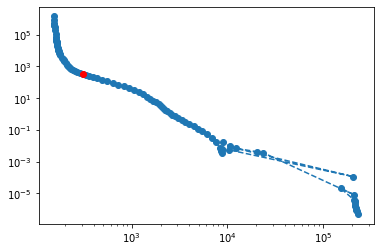

In [13]:
idx = 40
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

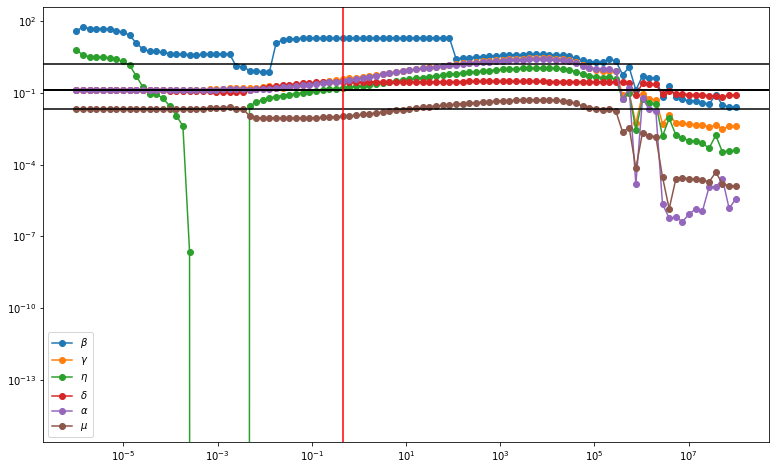

In [14]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()

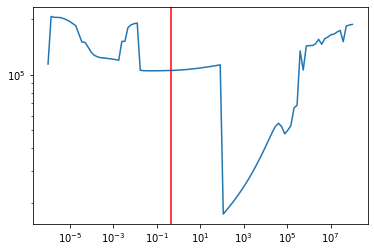

In [15]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')


(DM(2.47489), DM(0.836024), DM(0.430179), DM(0.285494), DM(0.945021), DM(0.020259))


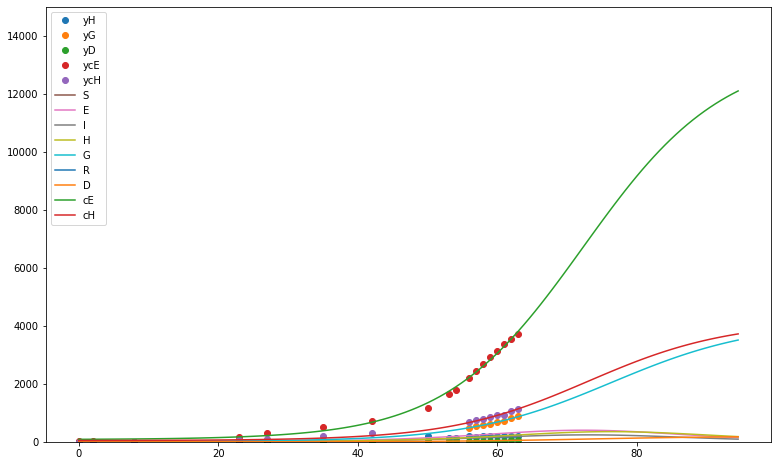

In [22]:
idx = 80
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([0, 15000])
print(getp(sols[idx]['x']))

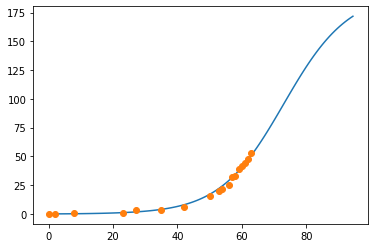

In [17]:
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')